In [1]:
import shap 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from torch.utils.data import DataLoader
import scipy
import torch_geometric as pyg 
import umap 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import gseapy as gp
import pickle as pkl 
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import confusion_matrix 
import omnipath as op
import matplotlib.patches as mpatches

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset
import captum

from src.interpret.extract_entity_function import extract_entity_function
from src.interpret.GSNNExplainer import GSNNExplainer 
from src.interpret.plot_explanation_graph import plot_explanation_graph, plot_hairball

from src.prioritize.utils import get_base_X, dose2scale, set_drug_concs
from src.uncertainty.utils import root_mean_squared_picp_error, compute_picp, compute_ECE

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GSNNExplainer Validation 

We will use [JENSEN Tissues](https://tissues.jensenlab.org/Search) to evaluate some of the contextual drug prediction graphs. 

Oana Palasca, Alberto Santos, Christian Stolte, Jan Gorodkin, Lars Juhl Jensen, TISSUES 2.0: an integrative web resource on mammalian tissue expression, Database, Volume 2018, 2018, bay003, https://doi.org/10.1093/database/bay003.

Santos A, Tsafou K, Stolte C, Pletscher-Frankild S, O'Donoghue SI, Jensen LJ. Comprehensive comparison of large-scale tissue expression datasets. PeerJ. 2015 Jun 30;3:e1054. doi: 10.7717/peerj.1054. PMID: 26157623; PMCID: PMC4493645.

In [2]:
# used for Edge Importance Scores model 
# model = torch.load('../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/model-100.pt').cpu().eval()
# data = torch.load('../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/Data.pt')
# proc = '../output/exp1/proc/'

model = torch.load('../output/from_exacloud/exp1/GSNN/FOLD-1/model-70.pt').cpu().eval()
data = torch.load('../output/from_exacloud/exp1/proc/Data.pt')
proc = '../output/from_exacloud/exp1/proc/'


siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)

jensen = pd.read_csv('../../data/human_tissue_integrated_full.tsv', sep='\t', header=None)
jensen.columns = ['gene_id', 'gene_name', 'tissue_id', 'tissue_name', 'score']

cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')[lambda x: x.cell_iname.isin(data.cellspace)]


In [3]:
overlap_tissues = set(cellinfo.cell_lineage.str.lower().tolist()).intersection(set(jensen.tissue_name.str.lower().tolist()))
len(overlap_tissues)

9

In [4]:
jensen = jensen[lambda x: x.tissue_name.str.lower().isin(overlap_tissues)]
jensen = jensen.assign(tissue_name = lambda x: x.tissue_name.str.lower())
jensen.head()

gene_id gene_name    tissue_id tissue_name  score
38   18S_rRNA  18S_rRNA  BTO:0000759       liver  2.756
47   18S_rRNA  18S_rRNA  BTO:0000671      kidney  2.700
68   18S_rRNA  18S_rRNA  BTO:0000763        lung  2.615
99   18S_rRNA  18S_rRNA  BTO:0000149      breast  2.441
100  18S_rRNA  18S_rRNA  BTO:0001253        skin  2.427

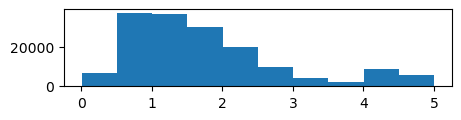

In [5]:
plt.figure(figsize=(5,1))
plt.hist(jensen.score)
plt.show()

In [6]:
jensen[lambda x: x.score > 0].groupby('tissue_name').count()[['gene_id']]

gene_id
tissue_name         
bone           12418
breast         18402
kidney         19582
liver          19406
lung           19965
ovary          18388
pancreas       18018
skin           18371
stomach        18023

In [7]:
cell_x_dict = {cell:get_base_X([cell], proc, data, siginfo) for cell in data.cellspace}

In [8]:
cellinfo[lambda x: x.cell_lineage.isin(overlap_tissues)][['cell_lineage', 'cell_iname']].groupby('cell_lineage').agg(list)

cell_iname
cell_lineage                                                   
bone                                              [SKES1, U2OS]
breast        [BT20, BT474, HS578T, MCF7, MDAMB231, MDAMB468...
kidney                                               [RCC10RGB]
liver                                             [HEPG2, HUH7]
lung          [A549, NCIH1437, NCIH1781, NCIH1975, NCIH2110,...
ovary         [ES2, TOV112D, COV434, OAW28, OVTOKO, OVK18, O...
pancreas                                                 [YAPC]
skin             [A375, SH4, SKMEL3, SKMEL5, IGR37, MELHO, CJM]
stomach                                            [AGS, MKN45]

In [18]:
data.cellspace

array(['22RV1', '5637', 'A204', 'A375', 'A549', 'AGS', 'BC3C', 'BEN',
       'BICR6', 'BT20', 'BT474', 'CAL29', 'CJM', 'COV434', 'CW2', 'DV90',
       'ES2', 'G401', 'GI1', 'GP2D', 'HCC95', 'HCT116', 'HEC108',
       'HEC151', 'HEC1A', 'HEC251', 'HEC265', 'HEPG2', 'HL60', 'HS578T',
       'HUH7', 'IGR37', 'J82', 'JURKAT', 'K562', 'KMS34', 'LN229', 'MCF7',
       'MDAMB231', 'MDAMB468', 'MELHO', 'MINO', 'MKN45', 'NALM6',
       'NCIH1437', 'NCIH1781', 'NCIH1975', 'NCIH2110', 'NCIH2172',
       'NCIH508', 'NCIH596', 'NCIH838', 'NCIH841', 'OAW28', 'OCILY19',
       'OCILY3', 'OVCAR8', 'OVK18', 'OVTOKO', 'PC3', 'RCC10RGB', 'SH4',
       'SKBR3', 'SKES1', 'SKMEL3', 'SKMEL5', 'SKNSH', 'SNU1040', 'SNU407',
       'T47D', 'THP1', 'TOV112D', 'U251MG', 'U2OS', 'U937', 'VCAP',
       'VMCUB1', 'YAPC', 'YH13', 'ZR751'], dtype='<U8')

In [80]:
cellinfo[['cell_lineage', 'cell_iname']][lambda x: x.cell_iname.isin(['HCT116',
                                                                                    'SKES1',
                                                                                    'BT20',
                                                                                    'RCC10RGB',
                                                                                    'HEPG2',
                                                                                    'A549',
                                                                                    'ES2',
                                                                                    'YAPC',
                                                                                    'A375',
                                                                                    'AGS'
                                                                                    'UTOS',
                                                                                    'MCF7',
                                                                                    'MDAMB231'])]

cell_lineage cell_iname
111             bone      SKES1
113             lung       A549
129             skin       A375
137  large_intestine     HCT116
146            liver      HEPG2
147           breast       BT20
151           breast       MCF7
152           breast   MDAMB231
162            ovary        ES2
190         pancreas       YAPC
235           kidney   RCC10RGB

In [81]:
gene2id = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

line_res = None

for i,row in cellinfo[['cell_lineage', 'cell_iname']][lambda x: x.cell_iname.isin(['HCT116',
                                                                                    'SKES1',
                                                                                    'BT20',
                                                                                    'RCC10RGB',
                                                                                    'HEPG2',
                                                                                    'A549',
                                                                                    'ES2',
                                                                                    'YAPC',
                                                                                    'A375',
                                                                                    'AGS'
                                                                                    'UTOS',
                                                                                    'MCF7',
                                                                                    'MDAMB231'])].iterrows():
    print(i, row.cell_iname, row.cell_lineage)
    ##############################################
    targ_line = row.cell_iname #'HEPG2' #'BT20' 
    back_line = row.cell_iname #'HEPG2' #'BT20'

    targ_drugs = ['BRD-K50691590']
    targ_doses = [1.]

    back_drugs = []
    back_doses = []

    xx_no_drug = cell_x_dict[targ_line].detach().clone()
    xx0_no_drug = cell_x_dict[back_line].detach().clone()

    xx = set_drug_concs(xx_no_drug, targ_drugs, targ_doses, data, verbose=False)
    xx0 = set_drug_concs(xx0_no_drug, back_drugs, back_doses, data, verbose=False)

    ##############################################

    explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-1, targets=data.output_node_mask, iters=100, lr=5e-2, weight_decay=0, 
                                    beta=1e-4, verbose=True, optimizer=torch.optim.Adam, free_edges=1000)

    res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=xx0.unsqueeze(-1), x=xx.unsqueeze(-1), return_predictions=True)

    # protein score will be the maximum out-going edge score 
    #res.score = res.score.astype(np.float16)
    res2 = res.rename({'score':f'{row.cell_iname}::{row.cell_lineage}'}, axis=1)

    if line_res is None: 
        line_res = res2 
    else: 
        line_res = line_res.merge(res2, on=['source', 'target'])


111 SKES1 bone
iter: 99 | mse: 0.82378882 | r2: 0.641 | active edges: 5996.00
Final r2 (MLE): 0.7550130802555415
113 A549 lung
iter: 99 | mse: 1.28244162 | r2: 0.757 | active edges: 6455.000
Final r2 (MLE): 0.8267372398800548
129 A375 skin
iter: 99 | mse: 3.77037477 | r2: 0.791 | active edges: 8143.000
Final r2 (MLE): 0.9015417278945786
137 HCT116 large_intestine
iter: 99 | mse: 1.80996430 | r2: 0.767 | active edges: 6518.000
Final r2 (MLE): 0.8405265994010036
146 HEPG2 liver
iter: 99 | mse: 2.58757973 | r2: 0.799 | active edges: 7620.00
Final r2 (MLE): 0.8977395762372501
147 BT20 breast
iter: 99 | mse: 0.76600993 | r2: 0.724 | active edges: 5818.000
Final r2 (MLE): 0.8088702289297638
151 MCF7 breast
iter: 99 | mse: 1.82441258 | r2: 0.814 | active edges: 6345.000
Final r2 (MLE): 0.8869156205572476
152 MDAMB231 breast
iter: 99 | mse: 2.42867923 | r2: 0.865 | active edges: 8053.0.00
Final r2 (MLE): 0.9272013173968167
162 ES2 ovary
iter: 99 | mse: 1.00204921 | r2: 0.628 | active edges: 67

In [82]:
line_res = line_res.assign(score_var = line_res[line_res.columns[2:]].var(axis=1))
line_res = line_res.assign(score_mean = line_res[line_res.columns[2:]].mean(axis=1))
line_res.head()

source       target  SKES1::bone  A549::lung  A375::skin  \
0  PROTEIN__P04637  RNA__P08069     0.011807    0.754148    0.987804   
1  PROTEIN__P40763  RNA__P38936     0.941585    0.979369    0.993050   
2  PROTEIN__P04637  RNA__P38936     0.963769    0.343640    0.832198   
3  PROTEIN__P04637  RNA__P06400     0.996972    0.998002    0.990825   
4  PROTEIN__Q01094  RNA__P38936     0.982118    0.503629    0.286389   

   HCT116::large_intestine  HEPG2::liver  BT20::breast  MCF7::breast  \
0                 0.450833      0.523766      0.959252      0.019292   
1                 0.695326      0.949589      0.989284      0.965853   
2                 0.930829      0.536745      0.997527      0.939120   
3                 0.821590      0.804141      0.926273      0.759332   
4                 0.961496      0.427104      0.996701      0.958803   

   MDAMB231::breast  ES2::ovary  YAPC::pancreas  RCC10RGB::kidney  score_var  \
0          0.742647    0.927918        0.992790          0.015204   0.163443   
1          0.987231    0.997162        0.984886          0.974156   0.007485   
2          0.994840    0.994449        0.919303          0.928037   0.045668   
3          0.994771    0.937164        0.420339          0.993994   0.030636   
4          0.982601    0.997303        0.984707          0.996605   0.075188   

   score_mean  
0    0.545742  
1    0.872081  
2    0.785510  
3    0.806170  
4    0.762720

In [83]:
gene2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

res = line_res
res[['source_gene_a', 'gene_a']] = res.source.str.split('__', expand=True)
res[['source_gene_b', 'gene_b']] = res.target.str.split('__', expand=True)
res = res[lambda x: x.source_gene_a == 'PROTEIN']
res = res[lambda x: x.source_gene_b == 'PROTEIN']
res = res.assign(gene_a = lambda x: [gene2symb[xx] for xx in x.gene_a])
res = res.assign(gene_b = lambda x: [gene2symb[xx] for xx in x.gene_b])
res.head()

source           target  SKES1::bone  A549::lung  A375::skin  \
566  PROTEIN__P16220  PROTEIN__P60568     0.645789    0.254591    0.808598   
567  PROTEIN__P16220  PROTEIN__P60568     0.645789    0.254591    0.808598   
568  PROTEIN__P16220  PROTEIN__P60568     0.645789    0.254591    0.808598   
569  PROTEIN__P16220  PROTEIN__P60568     0.645789    0.254591    0.808598   
570  PROTEIN__P16220  PROTEIN__P60568     0.645789    0.254591    0.808598   

     HCT116::large_intestine  HEPG2::liver  BT20::breast  MCF7::breast  \
566                 0.181755      0.666406      0.792181      0.815235   
567                 0.181755      0.666406      0.792181      0.815235   
568                 0.181755      0.666406      0.792181      0.815235   
569                 0.181755      0.666406      0.792181      0.815235   
570                 0.181755      0.666406      0.792181      0.815235   

     MDAMB231::breast  ES2::ovary  YAPC::pancreas  RCC10RGB::kidney  \
566          0.743153    0.984383        0.713746          0.821468   
567          0.743153    0.984383        0.713746          0.672003   
568          0.743153    0.984383        0.341715          0.821468   
569          0.743153    0.984383        0.341715          0.672003   
570          0.743153    0.987547        0.713746          0.821468   

     score_var  score_mean source_gene_a gene_a source_gene_b gene_b  
566   0.059552    0.623905       PROTEIN  CREB1       PROTEIN    IL2  
567   0.057211    0.611254       PROTEIN  CREB1       PROTEIN    IL2  
568   0.069267    0.593712       PROTEIN  CREB1       PROTEIN    IL2  
569   0.065915    0.580977       PROTEIN  CREB1       PROTEIN    IL2  
570   0.059749    0.624185       PROTEIN  CREB1       PROTEIN    IL2

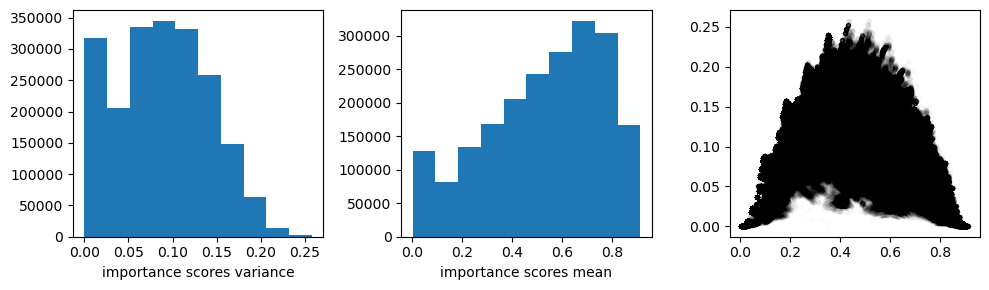

In [84]:
f,axes = plt.subplots(1,3,figsize=(10,3))
axes[0].hist(res.score_var)
axes[0].set_xlabel('importance scores variance')
axes[1].set_xlabel('importance scores mean')
axes[1].hist(line_res.score_mean)
axes[2].plot(line_res.score_mean, line_res.score_var, 'k.', alpha=0.01)
plt.tight_layout()
plt.show()

In [85]:
ppi_context = pd.read_csv('../../data/ppi_context_v_1_00.txt', sep='\t')
ppi_context.head()

id   gene_a   gene_b       pid cell_name  \
0   0  ALDH1A1  ALDH1A1  25416956       HEK   
1   2  PPP1R9A    ACTG1   9362513      Rat1   
2   2  PPP1R9A    ACTG1   9362513      PC12   
3   2  PPP1R9A    ACTG1   9362513       Sf9   
4   2  PPP1R9A    ACTG1   9362513     COS-7   

                          cell_category cell_sex           cell_species  
0                      Cancer cell line   Female           Homo sapiens  
1  Spontaneously immortalized cell line      NaN      Rattus norvegicus  
2                      Cancer cell line     Male      Rattus norvegicus  
3  Spontaneously immortalized cell line   Female  Spodoptera frugiperda  
4                 Transformed cell line     Male   Chlorocebus aethiops

In [86]:
res.columns

Index(['source', 'target', 'SKES1::bone', 'A549::lung', 'A375::skin',
       'HCT116::large_intestine', 'HEPG2::liver', 'BT20::breast',
       'MCF7::breast', 'MDAMB231::breast', 'ES2::ovary', 'YAPC::pancreas',
       'RCC10RGB::kidney', 'score_var', 'score_mean', 'source_gene_a',
       'gene_a', 'source_gene_b', 'gene_b'],
      dtype='object')

In [87]:

for context in ['HCT 116', 'U2OS', 'MCF-7', 'MDA-MB-231']: 
   print('CONTEXT', context)
   context_df = ppi_context[lambda x: x.cell_name==context].assign(context=True).merge(res, on=['gene_a', 'gene_b'], how='right')

   for line in ['SKES1::bone', 'A549::lung', 'A375::skin',
       'HCT116::large_intestine', 'HEPG2::liver', 'BT20::breast',
       'MCF7::breast', 'MDAMB231::breast', 'ES2::ovary', 'YAPC::pancreas',
       'RCC10RGB::kidney']: 
      try: 
         #tmp = hct_df[lambda x: ~((x.score_var < 0.05) & (x.score_mean < 0.2))]
         tmp = context_df[lambda x: ~((x.score_var < 0.05) & (x.score_mean < 0.2))]
         _ppi = tmp.context.fillna(0).astype(float).values
         score = tmp[line].values
         auroc = roc_auc_score(_ppi, score)
         print('\t', line, '\t', auroc)
      except:
         print('failed:', line)
   print()

CONTEXT HCT 116
	 SKES1::bone 	 0.6586475624080632
	 A549::lung 	 0.6619286025379091
	 A375::skin 	 0.5344364326652326
	 HCT116::large_intestine 	 0.6810536164939495
	 HEPG2::liver 	 0.6942184068186934
	 BT20::breast 	 0.6235117167490344
	 MCF7::breast 	 0.6426355786728671
	 MDAMB231::breast 	 0.6174948551577017
	 ES2::ovary 	 0.5882485990650097
	 YAPC::pancreas 	 0.6544729659538014
	 RCC10RGB::kidney 	 0.7020999645115198

CONTEXT U2OS
	 SKES1::bone 	 0.7599926617794832
	 A549::lung 	 0.7633397748864467
	 A375::skin 	 0.5577966776268155
	 HCT116::large_intestine 	 0.7510039085043403
	 HEPG2::liver 	 0.7351534080041554
	 BT20::breast 	 0.7131342870583779
	 MCF7::breast 	 0.7665019405872304
	 MDAMB231::breast 	 0.6694719466316958
	 ES2::ovary 	 0.6309459077105736
	 YAPC::pancreas 	 0.6906370818316327
	 RCC10RGB::kidney 	 0.7666929900684578

CONTEXT MCF-7
	 SKES1::bone 	 0.6871213449854653
	 A549::lung 	 0.7202812279899429
	 A375::skin 	 0.5353518937243206
	 HCT116::large_intestine 	 0.71

In [186]:
ppi_context[lambda x: x.cell_category == 'Cancer cell line'].groupby('cell_name').count().sort_values('id').tail(25)

id  gene_a  gene_b     pid  cell_category  cell_sex  \
cell_name                                                             
PANC 3.014    2208    2208    2208    2208           2208      2208   
R-3327-H      2324    2324    2324    2324           2324      2324   
NTERA-2       2650    2650    2650    2650           2650      2650   
NCI-H1299     2660    2660    2657    2660           2660      2660   
LNCaP         2697    2697    2695    2697           2697      2697   
H1HeLa        2805    2805    2805    2805           2805      2805   
LS513         3487    3487    3487    3487           3487      3487   
NCI-H1975     3550    3550    3550    3550           3550      3550   
JON           3641    3641    3641    3641           3641      3641   
Hep-G2        3854    3854    3854    3854           3854      3854   
MDA-MB-231    4189    4187    4187    4189           4189      4189   
K-562         4201    4201    4197    4201           4201      4201   
HT-29         4271    4271    4271    4271           4271      4271   
SW480         4351    4351    4351    4351           4351      4351   
Jurkat        6245    6245    6245    6245           6245      6245   
MCF-7         6580    6578    6578    6580           6580      6580   
DU145         8129    8129    8123    8129           8129      8129   
BL-21        12015   12007   11989   12015          12015     12015   
HeLa Kyoto   17103   17103   17093   17103          17103     17103   
HEK          20476   20426   20431   20476          20476     20476   
U2OS         26238   26238   26221   26238          26238     26238   
SH-SY5Y      27974   27968   27969   27974          27974     27974   
HeLa S3      39911   39911   39911   39911          39911     39911   
HCT 116      85386   85378   85374   85386          85386     85386   
HeLa        179459  179448  179418  179459         179459    179459   

            cell_species  
cell_name                 
PANC 3.014          2208  
R-3327-H            2324  
NTERA-2             2650  
NCI-H1299           2660  
LNCaP               2697  
H1HeLa              2805  
LS513               3487  
NCI-H1975           3550  
JON                 3641  
Hep-G2              3854  
MDA-MB-231          4189  
K-562               4201  
HT-29               4271  
SW480               4351  
Jurkat              6245  
MCF-7               6580  
DU145               8129  
BL-21              12015  
HeLa Kyoto         17103  
HEK                20476  
U2OS               26238  
SH-SY5Y            27974  
HeLa S3            39911  
HCT 116            85386  
HeLa              179459

In [187]:
data.cellspace

array(['22RV1', '5637', 'A204', 'A375', 'A549', 'AGS', 'BC3C', 'BEN',
       'BICR6', 'BT20', 'BT474', 'CAL29', 'CJM', 'COV434', 'CW2', 'DV90',
       'ES2', 'G401', 'GI1', 'GP2D', 'HCC95', 'HCT116', 'HEC108',
       'HEC151', 'HEC1A', 'HEC251', 'HEC265', 'HEPG2', 'HL60', 'HS578T',
       'HUH7', 'IGR37', 'J82', 'JURKAT', 'K562', 'KMS34', 'LN229', 'MCF7',
       'MDAMB231', 'MDAMB468', 'MELHO', 'MINO', 'MKN45', 'NALM6',
       'NCIH1437', 'NCIH1781', 'NCIH1975', 'NCIH2110', 'NCIH2172',
       'NCIH508', 'NCIH596', 'NCIH838', 'NCIH841', 'OAW28', 'OCILY19',
       'OCILY3', 'OVCAR8', 'OVK18', 'OVTOKO', 'PC3', 'RCC10RGB', 'SH4',
       'SKBR3', 'SKES1', 'SKMEL3', 'SKMEL5', 'SKNSH', 'SNU1040', 'SNU407',
       'T47D', 'THP1', 'TOV112D', 'U251MG', 'U2OS', 'U937', 'VCAP',
       'VMCUB1', 'YAPC', 'YH13', 'ZR751'], dtype='<U8')

In [240]:
data.drugspace.tolist().index('BRD-K50691590')

307

In [247]:
targ_line = 'SKBR3' #'HCT116'
back_line = 'SKBR3' #'HCT116'

targ_drugs = ['BRD-K50691590'] # data.drugspace.tolist() #['BRD-K50691590']
targ_doses = [1.] # [0.01 for _ in targ_drugs] #[1.]

back_drugs = []
back_doses = []

xx_no_drug = cell_x_dict[targ_line].detach().clone()
xx0_no_drug = cell_x_dict[back_line].detach().clone()

xx = set_drug_concs(xx_no_drug, targ_drugs, targ_doses, data, verbose=False)
xx0 = set_drug_concs(xx0_no_drug, back_drugs, back_doses, data, verbose=False)

##############################################

explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                        prior=-2, targets=data.output_node_mask, iters=100, lr=1e-2, weight_decay=0, 
                                beta=1e-5, verbose=True, optimizer=torch.optim.Adam, free_edges=1000)

res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=xx0.unsqueeze(-1), x=xx.unsqueeze(-1), return_predictions=True)

iter: 99 | mse: 0.45786393 | r2: 0.825 | active edges: 16745.0
Final r2 (MLE): 0.9999999999998499


In [248]:
res[['source_gene_a', 'gene_a']] = res.source.str.split('__', expand=True)
res[['source_gene_b', 'gene_b']] = res.target.str.split('__', expand=True)
res = res[lambda x: x.source_gene_a == 'PROTEIN']
res = res[lambda x: x.source_gene_b == 'PROTEIN']
res = res.assign(gene_a = lambda x: [gene2symb[xx] for xx in x.gene_a])
res = res.assign(gene_b = lambda x: [gene2symb[xx] for xx in x.gene_b])
res.head()

source           target     score source_gene_a  gene_a  \
566  PROTEIN__P16220  PROTEIN__P60568  0.989523       PROTEIN   CREB1   
567  PROTEIN__P31749  PROTEIN__O15111  0.986189       PROTEIN    AKT1   
568  PROTEIN__P27986  PROTEIN__P31749  0.962286       PROTEIN  PIK3R1   
569  PROTEIN__P38936  PROTEIN__P06493  0.992024       PROTEIN  CDKN1A   
570  PROTEIN__Q93009  PROTEIN__Q00987  0.967095       PROTEIN    USP7   

    source_gene_b gene_b  
566       PROTEIN    IL2  
567       PROTEIN   CHUK  
568       PROTEIN   AKT1  
569       PROTEIN   CDK1  
570       PROTEIN   MDM2

In [249]:
hct_df = ppi_context[lambda x: x.cell_name=='HCT 116'].assign(HCT116=True).merge(res, on=['gene_a', 'gene_b'], how='right')
hct_df.head()

id  gene_a gene_b  pid cell_name cell_category cell_sex cell_species  \
0 NaN   CREB1    IL2  NaN       NaN           NaN      NaN          NaN   
1 NaN    AKT1   CHUK  NaN       NaN           NaN      NaN          NaN   
2 NaN  PIK3R1   AKT1  NaN       NaN           NaN      NaN          NaN   
3 NaN  CDKN1A   CDK1  NaN       NaN           NaN      NaN          NaN   
4 NaN    USP7   MDM2  NaN       NaN           NaN      NaN          NaN   

  HCT116           source           target     score source_gene_a  \
0    NaN  PROTEIN__P16220  PROTEIN__P60568  0.989523       PROTEIN   
1    NaN  PROTEIN__P31749  PROTEIN__O15111  0.986189       PROTEIN   
2    NaN  PROTEIN__P27986  PROTEIN__P31749  0.962286       PROTEIN   
3    NaN  PROTEIN__P38936  PROTEIN__P06493  0.992024       PROTEIN   
4    NaN  PROTEIN__Q93009  PROTEIN__Q00987  0.967095       PROTEIN   

  source_gene_b  
0       PROTEIN  
1       PROTEIN  
2       PROTEIN  
3       PROTEIN  
4       PROTEIN

In [250]:
HCT_ppi = hct_df.HCT116.fillna(0).astype(float).values
score = hct_df.score.values
auroc = roc_auc_score(HCT_ppi, score)
auroc

0.5981826414916807

In [245]:
N = 1000
rand_aucs = [roc_auc_score(HCT_ppi, np.random.rand(score.shape[0])) for _ in range(N)]
print('mean:', np.mean(rand_aucs))
print('std:', np.std(rand_aucs))
print('p val:', np.mean(np.array(rand_aucs) >= auroc))

mean: 0.4997938030250757
std: 0.016543941595609096
p val: 0.0


In [32]:
# importance scores are very similar between cellular contexts. makes sense. 
#line_res.corr()

In [56]:
gene2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

In [138]:
line_zscore = line_res.T#.apply(scipy.stats.zscore)
line_zscore.columns = [gene2symb[x.split('__')[-1]] for x in line_zscore.columns]
line_zscore.head()

PSMB11      SGK1    PSMD11    PSMD12     PSMD9    PIK3CD  \
SKES1::bone     0.057827  0.985056  0.062969  0.061816  0.892883  0.969669   
U2OS::bone      0.056276  0.985489  0.053501  0.061355  0.982879  0.984912   
A549::lung      0.065301  0.982220  0.133719  0.064816  0.853825  0.982539   
NCIH1437::lung  0.060778  0.992612  0.089866  0.060238  0.971175  0.986677   
NCIH1781::lung  0.051412  0.979551  0.381414  0.061569  0.918494  0.955411   

                    WASL    PIK3R2    PSMD14      NRG2  ...     CARD8  \
SKES1::bone     0.056526  0.990232  0.065543  0.066593  ...  0.062095   
U2OS::bone      0.063249  0.991518  0.061772  0.069824  ...  0.067819   
A549::lung      0.073487  0.985381  0.056562  0.061897  ...  0.058096   
NCIH1437::lung  0.133263  0.987150  0.053594  0.067805  ...  0.054310   
NCIH1781::lung  0.747366  0.991354  0.063626  0.061349  ...  0.056844   

                   NOSIP    ZDHHC9     NR2E1      TLN1   RAPGEF2      IRS2  \
SKES1::bone     0.059578  0.058398  0.066492  0.904016  0.056750  0.973072   
U2OS::bone      0.056568  0.061089  0.710743  0.962780  0.786748  0.988094   
A549::lung      0.113062  0.055396  0.056727  0.965717  0.058548  0.973577   
NCIH1437::lung  0.057869  0.056421  0.056642  0.980064  0.055681  0.985868   
NCIH1781::lung  0.056075  0.062699  0.071581  0.991891  0.060327  0.993195   

                   TRAF6      EPN1    DUSP10  
SKES1::bone     0.614993  0.121384  0.069592  
U2OS::bone      0.908639  0.432115  0.742160  
A549::lung      0.072263  0.949576  0.103570  
NCIH1437::lung  0.455341  0.670958  0.248416  
NCIH1781::lung  0.804770  0.991491  0.624251  

[5 rows x 450 columns]

In [178]:
jensen_zscore = jensen[['gene_name','tissue_name', 'score']][lambda x: x.score > 3].pivot(index='tissue_name', columns='gene_name').fillna(0)
jensen_zscore = (jensen_zscore > 0).astype(float) 
jensen_zscore = jensen_zscore#.apply(scipy.stats.zscore)
jensen_zscore.columns = jensen_zscore.columns.get_level_values(1)
jensen_zscore.head()

gene_name    A1BG  A1CF  A2M  A2ML1  A4GNT  AAAS  AACS  AADAC  AADACL2  AADAT  \
tissue_name                                                                     
bone          0.0   0.0  0.0    0.0    0.0   0.0   0.0    0.0      0.0    0.0   
breast        1.0   0.0  0.0    0.0    0.0   0.0   1.0    0.0      0.0    0.0   
kidney        0.0   0.0  1.0    0.0    0.0   1.0   1.0    0.0      0.0    0.0   
liver         1.0   1.0  1.0    0.0    0.0   1.0   0.0    1.0      0.0    1.0   
lung          0.0   0.0  1.0    0.0    0.0   0.0   0.0    0.0      0.0    0.0   

gene_name    ...  ZSCAN25  ZSCAN26  ZSCAN29  ZSCAN32  ZSWIM8  ZUP1  ZXDC  ZYX  \
tissue_name  ...                                                                
bone         ...      0.0      0.0      0.0      0.0     0.0   0.0   0.0  0.0   
breast       ...      0.0      0.0      0.0      1.0     0.0   0.0   0.0  0.0   
kidney       ...      0.0      1.0      0.0      0.0     0.0   1.0   0.0  1.0   
liver        ...      0.0      0.0      1.0      0.0     1.0   1.0   1.0  1.0   
lung         ...      1.0      0.0      0.0      0.0     0.0   0.0   0.0  1.0   

gene_name    ZZEF1  hsa-miR-122-5p  
tissue_name                         
bone           0.0             0.0  
breast         0.0             0.0  
kidney         0.0             0.0  
liver          1.0             1.0  
lung           0.0             0.0  

[5 rows x 10361 columns]

In [179]:
overlapping_genes = list(set(list(line_zscore.dropna(axis=1).columns)).intersection(set(list(jensen_zscore.dropna(axis=1).columns))))
len(overlapping_genes)

352

In [180]:
corr_res = {'tissue':[], 'cell_line':[], 'r':[]}
for tissue in jensen_zscore.index: 
    for cell_line in line_zscore.index: 
        x1 = line_zscore.loc[cell_line][overlapping_genes].values
        x2 = jensen_zscore.loc[tissue][overlapping_genes].values
        r = scipy.stats.spearmanr(x1,x2)[1]
        corr_res['tissue'].append(tissue)
        corr_res['cell_line'].append(cell_line)
        corr_res['r'].append(r)

corr_res = pd.DataFrame(corr_res)
corr_res.head()

tissue       cell_line         r
0   bone     SKES1::bone  0.017137
1   bone      U2OS::bone  0.038900
2   bone      A549::lung  0.003470
3   bone  NCIH1437::lung  0.010039
4   bone  NCIH1781::lung  0.007707

In [181]:
corr_res = corr_res.pivot(index='tissue', columns='cell_line')
corr_res.columns = corr_res.columns.get_level_values(1)
corr_res

cell_line    A375::skin    A549::lung  AGS::stomach     BEN::lung  \
tissue                                                              
bone       1.206832e-01  3.469730e-03  8.371024e-03  1.003878e-02   
breast     3.413112e-09  4.384312e-08  7.267895e-08  1.463764e-07   
kidney     2.779196e-10  6.940797e-09  3.829545e-09  3.001731e-08   
liver      9.765058e-02  3.292275e-02  9.166705e-03  2.230331e-02   
lung       3.580148e-03  1.017560e-03  1.579387e-03  2.238623e-03   
ovary      7.859493e-07  1.865534e-08  2.102868e-10  1.939858e-09   
pancreas   8.602019e-06  2.077276e-05  4.485937e-07  2.507093e-06   
skin       5.531559e-05  9.956963e-05  3.315950e-05  1.319987e-04   
stomach    9.002704e-05  3.268332e-04  1.304905e-04  1.362903e-04   

cell_line  BT20::breast  BT474::breast     CJM::skin  COV434::ovary  \
tissue                                                                
bone       1.274339e-02   9.471866e-02  3.184233e-02   1.029056e-02   
breast     7.165335e-09   5.794810e-07  4.595441e-08   9.726048e-08   
kidney     9.314969e-08   2.329483e-07  5.551037e-12   3.546694e-11   
liver      1.709243e-02   3.524828e-02  1.659708e-02   1.773112e-03   
lung       9.233887e-04   6.893717e-03  1.326516e-04   1.545064e-04   
ovary      3.846173e-08   3.016707e-07  6.499879e-09   1.090689e-08   
pancreas   3.123659e-05   1.825949e-05  5.022371e-08   4.078157e-06   
skin       1.967180e-03   3.529338e-05  3.815734e-06   1.696558e-05   
stomach    1.196183e-03   6.942723e-04  3.806211e-05   6.159270e-05   

cell_line    DV90::lung    ES2::ovary  ...     SH4::skin  SKBR3::breast  \
tissue                                 ...                                
bone       6.778576e-02  3.403722e-01  ...  3.717425e-03   2.256252e-03   
breast     3.434290e-08  1.799503e-05  ...  1.283975e-09   8.548901e-07   
kidney     1.291513e-10  1.262379e-09  ...  5.951394e-11   1.817996e-09   
liver      2.188514e-02  5.429823e-03  ...  1.289907e-01   1.184241e-02   
lung       1.366465e-03  1.741054e-02  ...  7.400358e-03   2.125035e-04   
ovary      1.198654e-07  3.271853e-07  ...  3.493680e-09   1.041922e-09   
pancreas   4.422307e-06  8.317691e-06  ...  1.011164e-05   1.152082e-07   
skin       1.836914e-05  5.633033e-04  ...  4.977744e-06   1.285283e-04   
stomach    1.116127e-04  1.790568e-03  ...  2.416450e-04   3.630626e-04   

cell_line   SKES1::bone  SKMEL3::skin  SKMEL5::skin  T47D::breast  \
tissue                                                              
bone       1.713710e-02  8.318199e-03  5.350133e-02  1.149414e-02   
breast     1.530020e-06  3.764971e-07  1.420402e-07  3.604605e-07   
kidney     2.318727e-09  1.325350e-11  3.249954e-09  2.878685e-12   
liver      6.268999e-03  1.229411e-02  1.083255e-02  1.920527e-02   
lung       2.864446e-03  3.847898e-03  1.237884e-03  2.601039e-03   
ovary      1.272683e-08  2.622204e-10  2.170964e-08  4.668854e-10   
pancreas   4.422307e-06  9.096559e-06  4.396834e-06  9.458704e-06   
skin       1.718828e-04  1.606033e-05  1.123149e-05  3.675375e-06   
stomach    7.884101e-04  7.772237e-05  1.034922e-04  1.151698e-04   

cell_line  TOV112D::ovary    U2OS::bone  YAPC::pancreas  ZR751::breast  
tissue                                                                  
bone         5.219612e-02  3.889982e-02    9.429915e-02   4.348918e-03  
breast       1.098541e-07  1.352220e-06    4.021312e-08   5.420845e-10  
kidney       2.972504e-09  2.082491e-11    6.404971e-07   5.142525e-11  
liver        2.054425e-03  2.954571e-02    1.039084e-03   9.830943e-03  
lung         2.778277e-04  8.270946e-04    1.116362e-02   2.840427e-04  
ovary        5.837850e-09  7.868672e-10    9.146857e-06   2.949704e-10  
pancreas     3.485276e-06  9.725732e-06    1.240005e-06   1.659520e-06  
skin         4.335013e-07  1.160027e-04    5.091767e-04   2.615546e-06  
stomach      1.221934e-05  5.425155e-04    1.090523e-05   1.823156e-05  

[9 rows x 43 columns]

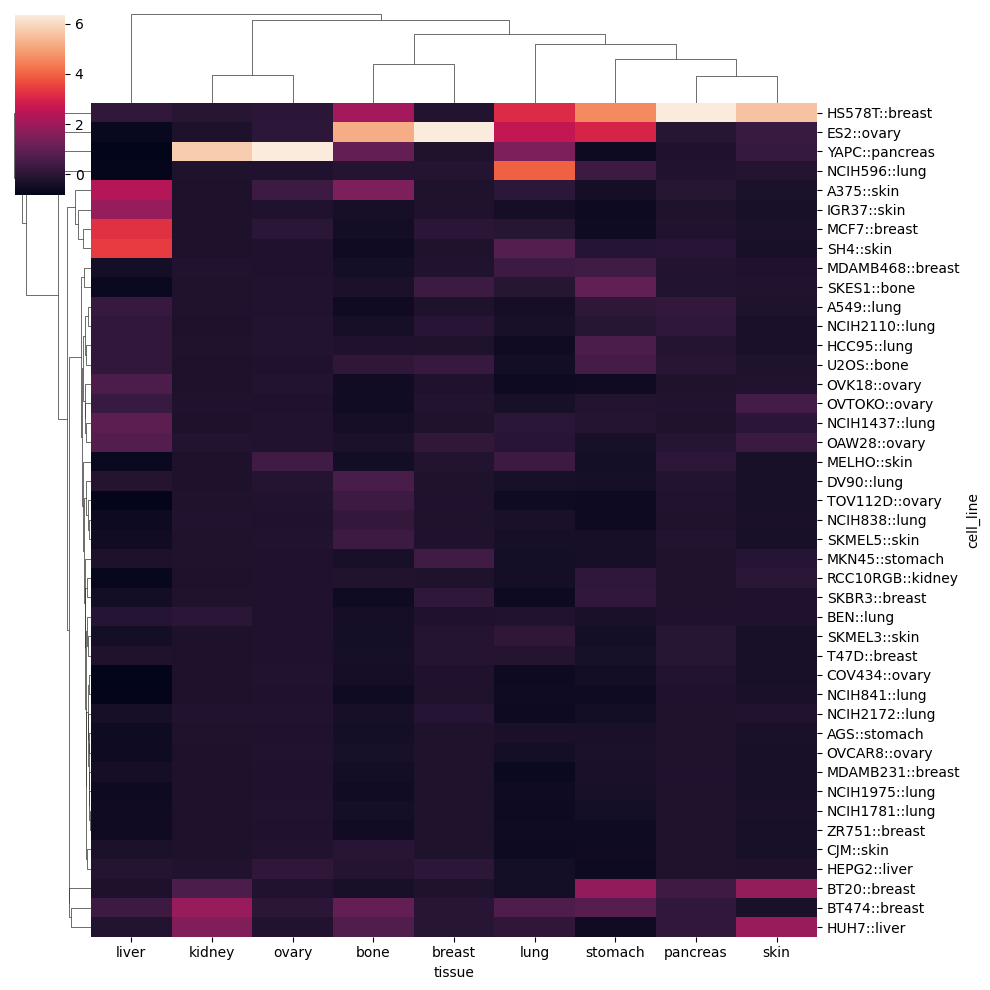

In [182]:
sbn.clustermap(corr_res.T, z_score=True, dendrogram_ratio=0.1)

In [203]:
# of the genes that are both in JENSEN and GSNN data ... how many are overlapping? 

for i,row in pd.DataFrame(line_prots).iterrows(): 

    jensen_res = {'tissue':[], 'num_jensen_genes':[], 'num_line_genes':[], 'num_overlap':[]}

    for tissue in overlap_tissues: 
        tmp = jensen[lambda x: (x.score > 3) & (x.gene_name.isin(all_involved_prots)) & (x.tissue_name == tissue)]
        tissue_genes = tmp.gene_name.unique().tolist()
        jensen_res['tissue'].append(tissue)
        jensen_res['num_jensen_genes'].append(len(tissue_genes))
        jensen_res['num_line_genes'].append(len(row['involved_proteins']))
        jensen_res['num_overlap'].append(len(row['involved_proteins'].intersection(set(tissue_genes))))

    jensen_res = pd.DataFrame(jensen_res)
    jensen_res = jensen_res.assign(prop_overlap = lambda x: x.num_overlap / x.num_jensen_genes)
    jensen_res = jensen_res.sort_values('prop_overlap').reset_index()

    rank = jensen_res[lambda x: x.tissue == row.cell_lineage].index
    print(row.cell_iname, row.cell_lineage, rank.item())





SKES1 bone 7
U2OS bone 2
A549 lung 3
NCIH1437 lung 1
NCIH1781 lung 1
NCIH1975 lung 1
NCIH2110 lung 2
NCIH2172 lung 1
NCIH596 lung 0
NCIH838 lung 2
NCIH841 lung 1
A375 skin 4
SH4 skin 2
SKMEL3 skin 3
SKMEL5 skin 1
HEPG2 liver 0
BT20 breast 5
BT474 breast 5
HS578T breast 6
MCF7 breast 5
MDAMB231 breast 8
MDAMB468 breast 5
SKBR3 breast 4
T47D breast 4
ZR751 breast 4
AGS stomach 5
ES2 ovary 7
TOV112D ovary 1
BEN lung 1
DV90 lung 2
IGR37 skin 3
MELHO skin 2
YAPC pancreas 7
HCC95 lung 0
COV434 ovary 5
OAW28 ovary 5
HUH7 liver 1
MKN45 stomach 1
OVTOKO ovary 6
CJM skin 6
RCC10RGB kidney 4
OVK18 ovary 4
OVCAR8 ovary 6


In [ ]:
rank.item()

3

In [ ]:
jensen_bt20 = jensen[lambda x: x.gene_name.isin(all_gene_symbs)].assign(important_in_bt20 = lambda x: x.gene_name.isin(prots_symbs))
jensen_bt20

gene_id gene_name    tissue_id tissue_name  score  \
61745    ENSP00000011619    RANBP9  BTO:0000763        lung  3.549   
61754    ENSP00000011619    RANBP9  BTO:0000671      kidney  2.370   
61757    ENSP00000011619    RANBP9  BTO:0000975       ovary  2.279   
61780    ENSP00000011619    RANBP9  BTO:0001253        skin  1.955   
61786    ENSP00000011619    RANBP9  BTO:0000759       liver  1.898   
...                  ...       ...          ...         ...    ...   
8377716  ENSP00000501150    PIK3CB  BTO:0000975       ovary  2.666   
8377721  ENSP00000501150    PIK3CB  BTO:0001253        skin  2.575   
8377727  ENSP00000501150    PIK3CB  BTO:0000988    pancreas  2.453   
8377746  ENSP00000501150    PIK3CB  BTO:0001307     stomach  2.204   
8377870  ENSP00000501150    PIK3CB  BTO:0000140        bone  1.603   

         important_in_bt20  
61745                False  
61754                False  
61757                False  
61780                False  
61786                False  
...                    ...  
8377716               True  
8377721               True  
8377727               True  
8377746               True  
8377870               True  

[4023 rows x 6 columns]

<Axes: xlabel='count', ylabel='tissue_name'>

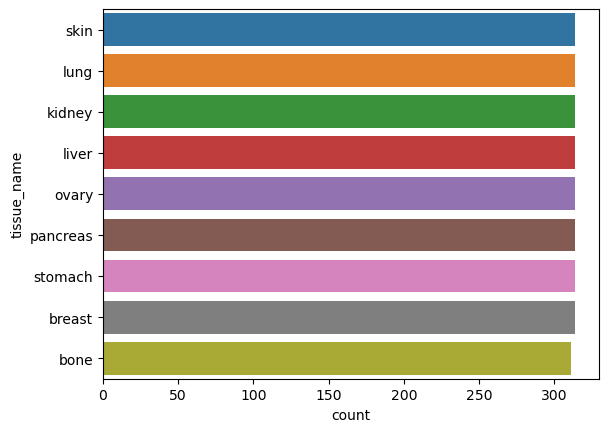

In [ ]:
plt.figure()
sbn.countplot(y='tissue_name', data=jensen_bt20[lambda x: x.important_in_bt20])

In [ ]:
jensen[lambda x: x.gene_name.isin(all_gene_symbs)]

gene_id gene_name    tissue_id tissue_name  score
61745    ENSP00000011619    RANBP9  BTO:0000763        lung  3.549
61754    ENSP00000011619    RANBP9  BTO:0000671      kidney  2.370
61757    ENSP00000011619    RANBP9  BTO:0000975       ovary  2.279
61780    ENSP00000011619    RANBP9  BTO:0001253        skin  1.955
61786    ENSP00000011619    RANBP9  BTO:0000759       liver  1.898
...                  ...       ...          ...         ...    ...
8377716  ENSP00000501150    PIK3CB  BTO:0000975       ovary  2.666
8377721  ENSP00000501150    PIK3CB  BTO:0001253        skin  2.575
8377727  ENSP00000501150    PIK3CB  BTO:0000988    pancreas  2.453
8377746  ENSP00000501150    PIK3CB  BTO:0001307     stomach  2.204
8377870  ENSP00000501150    PIK3CB  BTO:0000140        bone  1.603

[4023 rows x 5 columns]

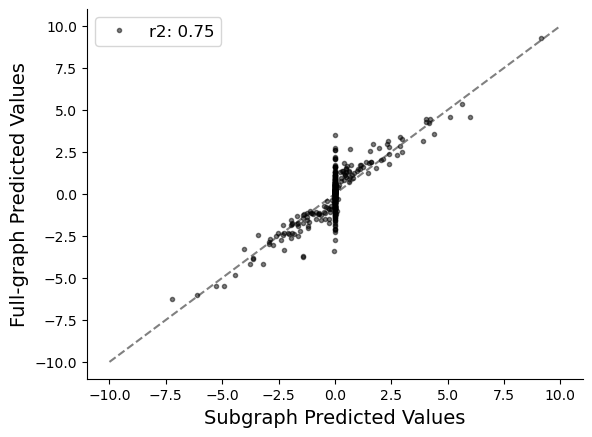

In [ ]:
ax = plt.subplot(111)
ax.plot((-10, 10), (-10, 10), c='gray', linestyle='--') 
ax.plot(subgraph_preds, full_graph_preds, 'k.', label=f'r2: {r2:.2f}', alpha=0.5) 
ax.set_xlabel('Subgraph Predicted Values', fontsize=14)
ax.set_ylabel('Full-graph Predicted Values', fontsize=14)
plt.legend(fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [ ]:
res.sort_values(by='score', ascending=False).head(5)

source         target     score
12157  RNA__P38936  LINCS__P38936  0.999985
12195  RNA__P52926  LINCS__P52926  0.999985
12279  RNA__Q14684  LINCS__Q14684  0.999980
12388  RNA__Q9ULJ6  LINCS__Q9ULJ6  0.999978
12266  RNA__Q14135  LINCS__Q14135  0.999977

In [ ]:
# HER2: PROTEIN__P04626
# EGFR: P00533
# lapatinib : BRD-K19687926
# neratinib : BRD-K85606544

drug_id = siginfo.iloc[idx].pert_id
print(drug_id)
res.set_index('source').loc[['DRUG__' + drug_id]]

BRD-K50691590


target     score
source                                        
DRUG__BRD-K50691590  PROTEIN__P20618  0.999075
DRUG__BRD-K50691590  PROTEIN__P28074  0.997973
DRUG__BRD-K50691590  PROTEIN__P49721  0.998170

In [ ]:
res[lambda x: x.score > 0.][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)

source           target     score
11640  DRUG__BRD-K50691590  PROTEIN__P20618  0.999075
11642  DRUG__BRD-K50691590  PROTEIN__P49721  0.998170
11641  DRUG__BRD-K50691590  PROTEIN__P28074  0.997973
11589  DRUG__BRD-K42898655  PROTEIN__P42345  0.004285
11575  DRUG__BRD-K41260949  PROTEIN__Q13547  0.004162
11558  DRUG__BRD-K36280065  PROTEIN__P52333  0.004135
11437  DRUG__BRD-K16478699  PROTEIN__P15056  0.004095
11456  DRUG__BRD-K17016787  PROTEIN__P03372  0.004038
11570  DRUG__BRD-K39520573  PROTEIN__P04049  0.003993
11859  DRUG__BRD-K85751432  PROTEIN__P36507  0.003931

full graph size: 505
largest comp. subgraph 482


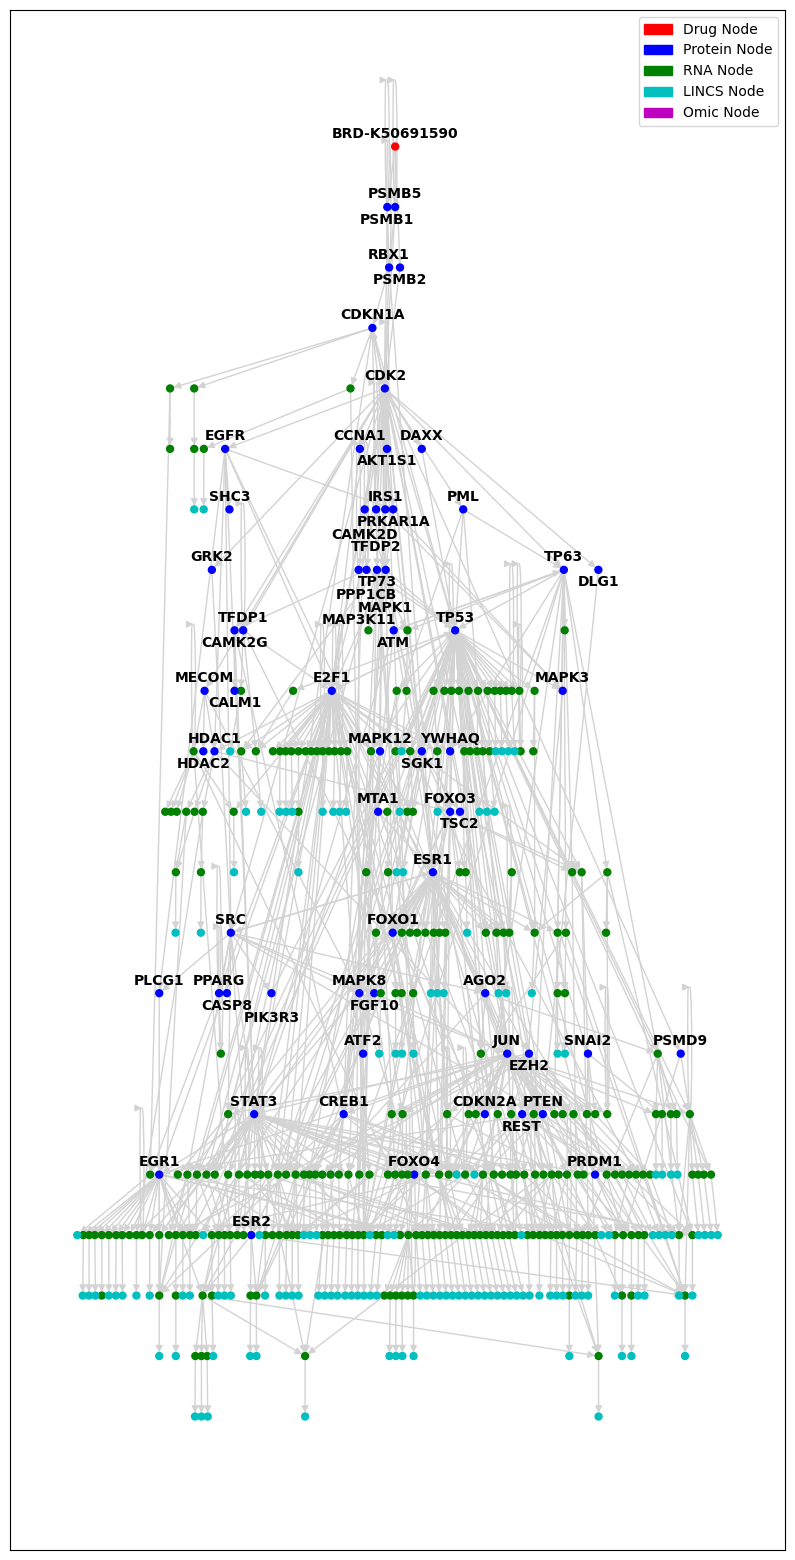

In [ ]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10)

Creating legend with loc="best" can be slow with large amounts of data.


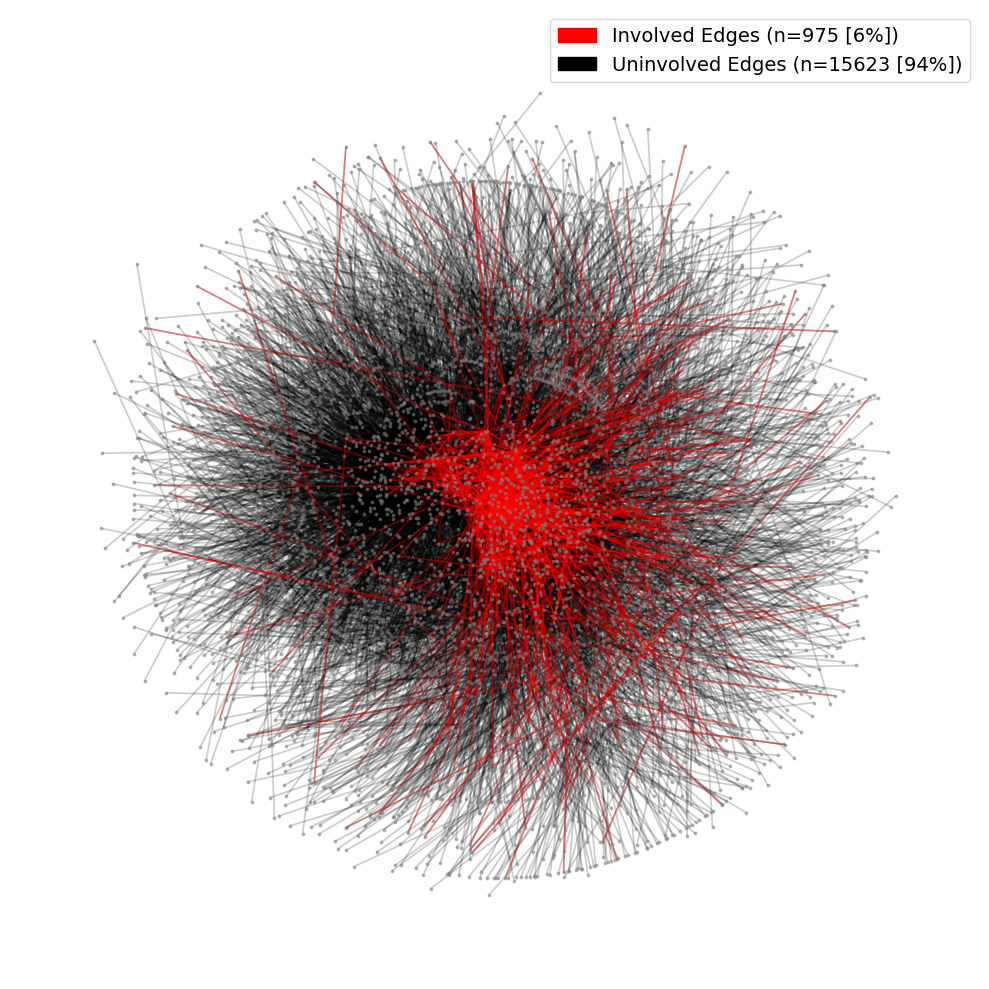

In [ ]:
plot_hairball(res, save=None, fontsize=14)

# Undertanding difference between two cell lines predictions 

In [ ]:
drug = 'BRD-K56957086'

siginfo[lambda x: (x.pert_id == drug) & (x.cell_iname.isin(['PC3', 'A375'])) & (x.nearest_dose == 10)]

index bead_batch  nearest_dose  pert_dose pert_dose_unit pert_idose  \
21819  21819        b23          10.0       10.0             uM      10 uM   
25826  25826        b23          10.0       10.0             uM      10 uM   

      pert_itime  pert_time pert_time_unit cell_mfc_name  ... cell_iname  \
21819       24 h       24.0              h           PC3  ...        PC3   
25826       24 h       24.0              h          A375  ...       A375   

       det_wells                                         det_plates  \
21819        E13  REP.A015_PC3_24H_X1_B23|REP.A015_PC3_24H_X2_B2...   
25826        E13  REP.A015_A375_24H_X1_B23|REP.A015_A375_24H_X2_...   

                                              distil_ids  build_name  \
21819  REP.A015_PC3_24H_X1_B23:E13|REP.A015_PC3_24H_X...         NaN   
25826  REP.A015_A375_24H_X1_B23:E13|REP.A015_A375_24H...         NaN   

       project_code   cmap_name  is_exemplar_sig  is_ncs_sig  is_null_sig  
21819           REP  dacinostat                0         1.0          0.0  
25826           REP  dacinostat                0         1.0          0.0  

[2 rows x 38 columns]

In [ ]:
x_baseline = X[[21819]] # PC3, dacinostat, 10uM
x_toexplain = X[[25826]] # A375, 

y_baseline = Y[[21819]]
y_toexplain = Y[[25826]]

yhat_baseline = model.cpu()(x_baseline)
yhat_toexplain = model.cpu()(x_toexplain)

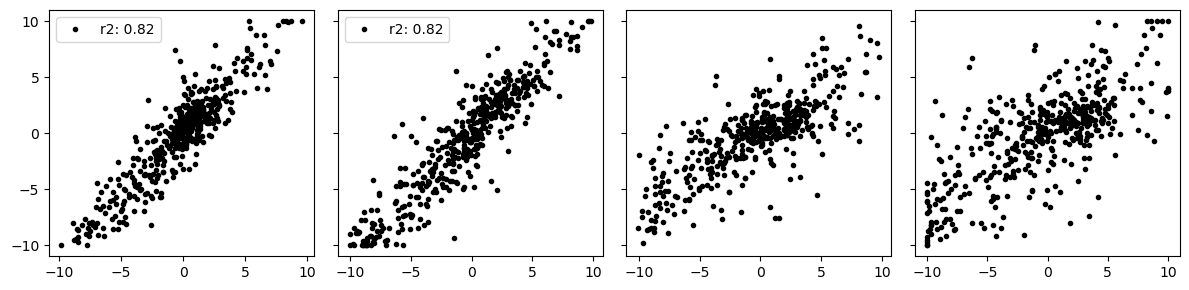

In [ ]:

f,axes = plt.subplots(1,4, figsize=(12,3), sharey=True)
axes.flat[0].plot(yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.', label=f'r2: {r2_score(y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel()):.2f}')
axes.flat[1].plot(yhat_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), y_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.', label=f'r2: {r2_score(y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel()):.2f}')
axes.flat[2].plot(yhat_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.')
axes.flat[3].plot(y_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.')
axes.flat[0].legend()
axes.flat[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=2000, lr=1e-2, weight_decay=0, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam, free_edges=500)

res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=x_baseline, x=x_toexplain, return_predictions=True)

WARNING! r2(yhat_x, yhat_baseline) > 0 - this indicates the model predicts similar outcomes for x and baseline. This may indicate poor observation prediction.
iter: 1999 | mse: 3.00449848 | r2: 0.615 | active edges: 1428.0
Final r2 (MLE): 0.6155026255280359


In [ ]:
res[lambda x: (x.source == 'PROTEIN__P03372')].sort_values('score', ascending=False).head(10)

source             target     score
78    PROTEIN__P03372        RNA__P07339  0.999960
482   PROTEIN__P03372        RNA__Q9UHN6  0.999959
6540  PROTEIN__P03372  RNA__MIMAT0004568  0.999956
69    PROTEIN__P03372        RNA__P31749  0.999937
6515  PROTEIN__P03372  RNA__MIMAT0000437  0.999916
6528  PROTEIN__P03372  RNA__MIMAT0000073  0.999905
492   PROTEIN__P03372        RNA__P18084  0.999904
507   PROTEIN__P03372        RNA__P47736  0.999848
6512  PROTEIN__P03372  RNA__MIMAT0004599  0.999843
517   PROTEIN__P03372        RNA__Q9ULJ6  0.999811

In [ ]:
res[lambda x: (x.target == 'RNA__Q8WYB5')].sort_values('score', ascending=False).head(5)

source       target     score
17504      RNA__Q8WYB5  RNA__Q8WYB5  0.999760
493    PROTEIN__P03372  RNA__Q8WYB5  0.999702
12835     EXPR__Q8WYB5  RNA__Q8WYB5  0.999021
14742      CNV__Q8WYB5  RNA__Q8WYB5  0.996146
13819   METHYL__Q8WYB5  RNA__Q8WYB5  0.000753

In [ ]:
res[lambda x: (x.source == 'RNA__Q8WYB5')].sort_values('score', ascending=False).head(5)

source         target    score
11979  RNA__Q8WYB5  LINCS__Q8WYB5  0.99997
17504  RNA__Q8WYB5    RNA__Q8WYB5  0.99976

In [ ]:
lincs_idx = np.where(data.node_names == 'LINCS__O60238')[0]
lincs_idx

array([2119])

In [ ]:
y_baseline.shape

torch.Size([1, 5369, 1])

In [ ]:
print('y PC3', y_baseline.squeeze()[[lincs_idx]]) 
print('y A375', y_toexplain.squeeze()[[lincs_idx]]) 
print('yhat PC3', yhat_baseline.squeeze()[[lincs_idx]]) 
print('yhat A375', yhat_toexplain.squeeze()[[lincs_idx]]) 

y PC3 tensor([-4.6964])
y A375 tensor([0.6546])
yhat PC3 tensor([-3.8842])
yhat A375 tensor([3.2761])


full graph size: 836
largest comp. subgraph 753


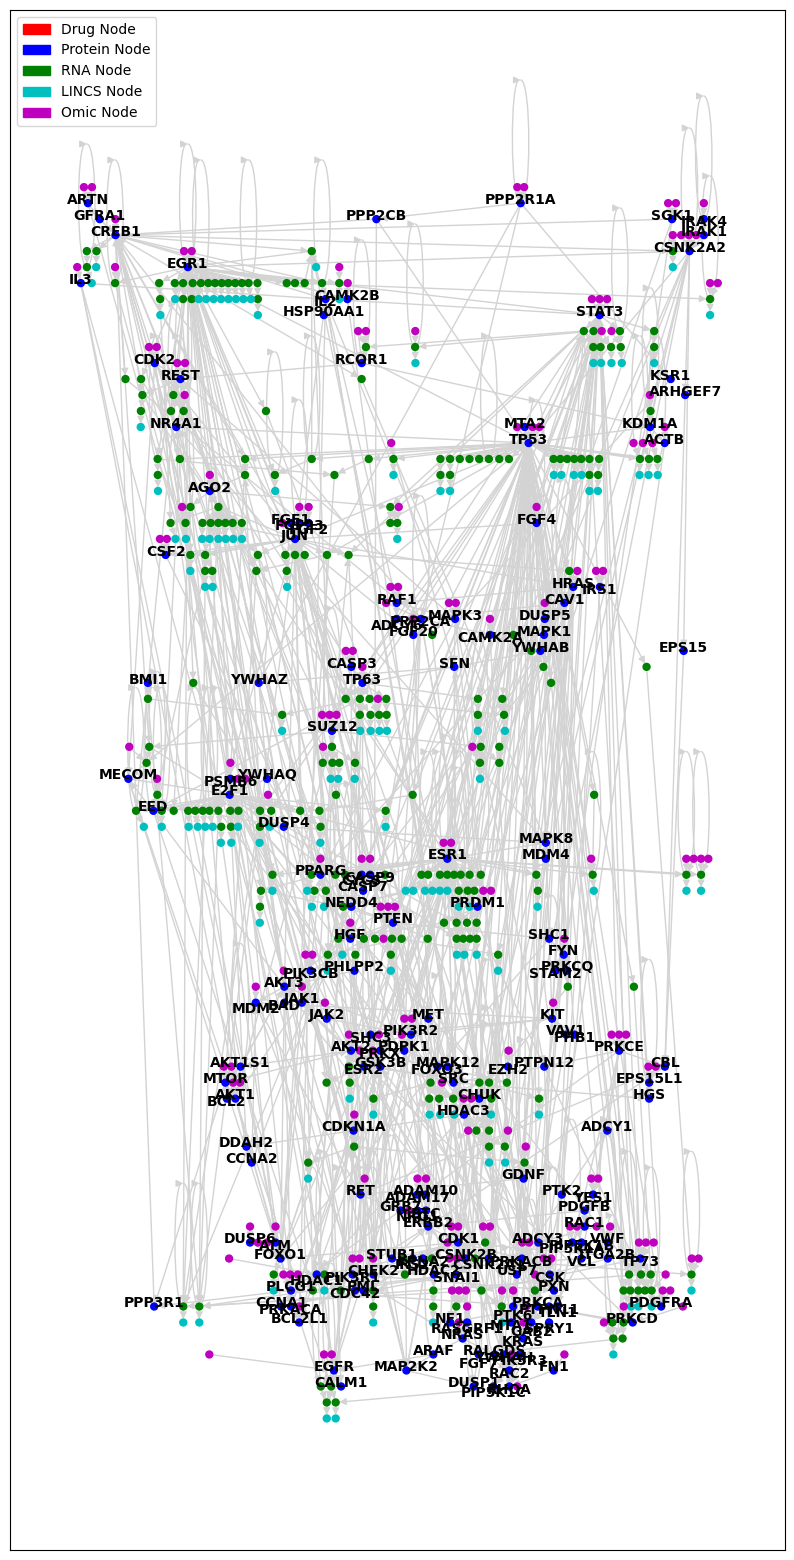

In [ ]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10)

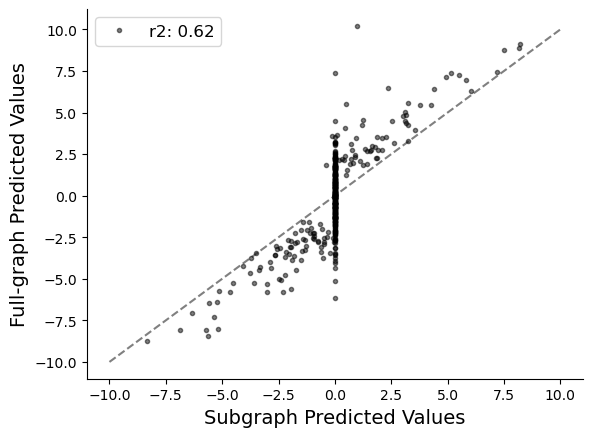

In [ ]:
ax = plt.subplot(111)
ax.plot((-10, 10), (-10, 10), c='gray', linestyle='--') 
ax.plot(subgraph_preds, full_graph_preds, 'k.', label=f'r2: {r2:.2f}', alpha=0.5) 
ax.set_xlabel('Subgraph Predicted Values', fontsize=14)
ax.set_ylabel('Full-graph Predicted Values', fontsize=14)
plt.legend(fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [ ]:
# idx=2000 # 20uM, PC3, BRD-K50691590
# idx=33373 # 20uM, MCF7, BRD-K50691590

explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=1000, lr=1e-2, weight_decay=1e-6, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam)

xx = X[[2000]]
xx0 = X[[33373]]

res, r2 = explainer.explain(baseline=xx0, x=xx)

iter: 999 | mse: 2.47934103 | r2: 0.736 | active edges: 1301.00
Final r2 (MLE): 0.7539806684700244


In [ ]:
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

In [ ]:
res = res.assign(source_symb = [uni2symb[x.split('__')[1]] if x.split('__')[1] in uni2symb else None for x in res.source.values])
res = res.assign(target_symb = [uni2symb[x.split('__')[1]] if x.split('__')[1] in uni2symb else None for x in res.target.values])
res.head()

source       target     score source_symb target_symb
0  PROTEIN__P04637  RNA__P08069  0.001888        TP53       IGF1R
1  PROTEIN__P40763  RNA__P38936  0.001977       STAT3      CDKN1A
2  PROTEIN__P04637  RNA__P38936  0.003031        TP53      CDKN1A
3  PROTEIN__P04637  RNA__P06400  0.001853        TP53         RB1
4  PROTEIN__Q01094  RNA__P38936  0.002333        E2F1      CDKN1A

In [ ]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('EXPR')].head(5)

source           target     score source_symb target_symb
13403  EXPR__P15056  PROTEIN__P15056  0.999895        BRAF        BRAF
13386  EXPR__P08581  PROTEIN__P08581  0.999870         MET         MET
13464  EXPR__P32121  PROTEIN__P32121  0.999847       ARRB2       ARRB2
13356  EXPR__O96017  PROTEIN__O96017  0.999837       CHEK2       CHEK2
13603  EXPR__Q14186  PROTEIN__Q14186  0.999813       TFDP1       TFDP1

In [ ]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('MUT')].head(5)

source           target     score source_symb target_symb
15772  MUT__P15407      RNA__P15407  0.999476       FOSL1       FOSL1
16364  MUT__P42336  PROTEIN__P42336  0.999360      PIK3CA      PIK3CA
16133  MUT__Q9HD45      RNA__Q9HD45  0.998587      TM9SF3      TM9SF3
16530  MUT__Q92529  PROTEIN__Q92529  0.998488        SHC3        SHC3
16368  MUT__P42574  PROTEIN__P42574  0.998222       CASP3       CASP3

In [ ]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('METHYL')].head(5)

source           target     score source_symb target_symb
14348  METHYL__P12931  PROTEIN__P12931  0.999796         SRC         SRC
14297  METHYL__O75626  PROTEIN__O75626  0.999768       PRDM1       PRDM1
14485  METHYL__Q02750  PROTEIN__Q02750  0.999743      MAP2K1      MAP2K1
14322  METHYL__P04049  PROTEIN__P04049  0.999711        RAF1        RAF1
14362  METHYL__P18146  PROTEIN__P18146  0.999642        EGR1        EGR1

In [ ]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('CNV')].head(5)

source           target     score source_symb target_symb
15256  CNV__P01589  PROTEIN__P01589  0.999889       IL2RA       IL2RA
15480  CNV__Q14186  PROTEIN__Q14186  0.999871       TFDP1       TFDP1
15290  CNV__P10721  PROTEIN__P10721  0.999853         KIT         KIT
15271  CNV__P05412  PROTEIN__P05412  0.999848         JUN         JUN
15283  CNV__P09619  PROTEIN__P09619  0.999835      PDGFRB      PDGFRB

In [ ]:
res.sort_values(by='score', ascending=False)[lambda x: x.target_symb == 'TP53'].head(25)

source           target     score source_symb target_symb
1937     PROTEIN__P27361  PROTEIN__P04637  0.999881       MAPK3        TP53
12042        RNA__P04637    LINCS__P04637  0.999869        TP53        TP53
3723     PROTEIN__O15151  PROTEIN__P04637  0.999862        MDM4        TP53
4429     PROTEIN__Q05655  PROTEIN__P04637  0.999849       PRKCD        TP53
685      PROTEIN__Q9H3D4  PROTEIN__P04637  0.999847        TP63        TP53
13373       EXPR__P04637  PROTEIN__P04637  0.999806        TP53        TP53
4768     PROTEIN__Q8N726  PROTEIN__P04637  0.999761      CDKN2A        TP53
1848     PROTEIN__P35232  PROTEIN__P04637  0.999750        PHB1        TP53
10772  RNA__MIMAT0002875      RNA__P04637  0.999741        None        TP53
8545   RNA__MIMAT0004556      RNA__P04637  0.999607        None        TP53
1865     PROTEIN__P45983  PROTEIN__P04637  0.999521       MAPK8        TP53
12785       EXPR__P04637      RNA__P04637  0.999369        TP53        TP53
803      PROTEIN__O60341  PROTEIN__P04637  0.999348       KDM1A        TP53
4369     PROTEIN__P45983  PROTEIN__P04637  0.999094       MAPK8        TP53
8819   RNA__MIMAT0004657      RNA__P04637  0.999043        None        TP53
2179     PROTEIN__Q13362  PROTEIN__P04637  0.999019     PPP2R5C        TP53
8665   RNA__MIMAT0004697      RNA__P04637  0.998457        None        TP53
3804     PROTEIN__Q13315  PROTEIN__P04637  0.998440         ATM        TP53
3596     PROTEIN__O15350  PROTEIN__P04637  0.998435        TP73        TP53
2016     PROTEIN__Q05655  PROTEIN__P04637  0.998241       PRKCD        TP53
4677     PROTEIN__P28482  PROTEIN__P04637  0.997518       MAPK1        TP53
15266        CNV__P04637  PROTEIN__P04637  0.997165        TP53        TP53
3083     PROTEIN__Q07817  PROTEIN__P04637  0.996802      BCL2L1        TP53
6733     PROTEIN__P05412  PROTEIN__P04637  0.996097         JUN        TP53
824      PROTEIN__O15151  PROTEIN__P04637  0.990801        MDM4        TP53

In [ ]:
print('baseline TP53 CNV', xx0[:, data.node_names.tolist().index('CNV__P04637'), :])
print('obs TP53 CNV', xx[:, data.node_names.tolist().index('CNV__P04637'), :])

baseline TP53 CNV tensor([[0.3507]])
obs TP53 CNV tensor([[-0.8768]])


In [ ]:
print('baseline TP53 EXPR', xx0[:, data.node_names.tolist().index('EXPR__P04637'), :])
print('obs TP53 EXPR', xx[:, data.node_names.tolist().index('EXPR__P04637'), :])

baseline TP53 EXPR tensor([[0.9611]])
obs TP53 EXPR tensor([[-2.4842]])


full graph size: 712
largest comp. subgraph 692


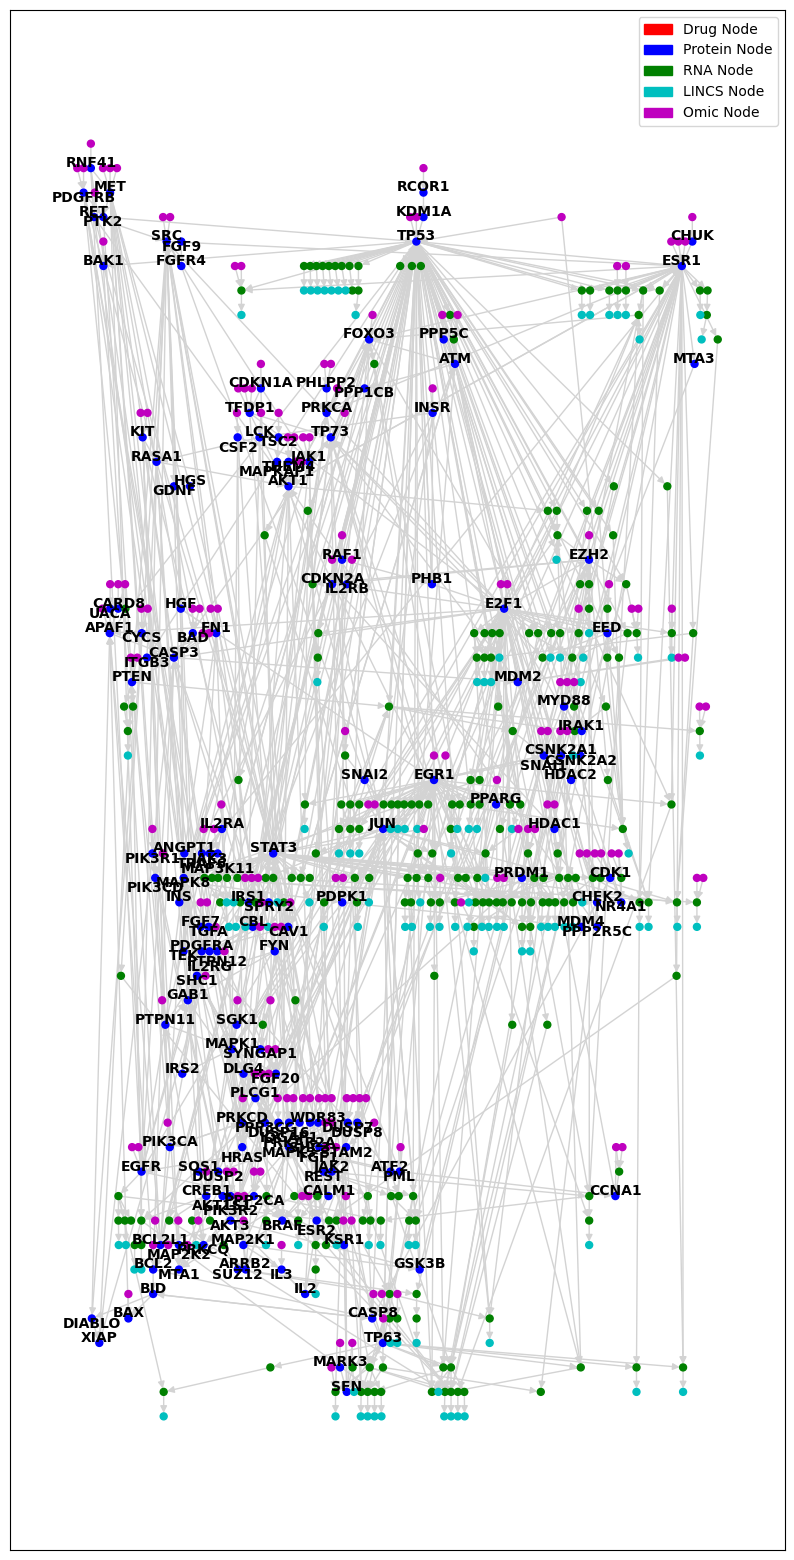

In [ ]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10)

In [ ]:
explainer = GSNNExplainer(model, data, gumbel_softmax=True, hard=False, prior=1, normalize_target=True)
NERATINIB_mcf7 = explainer.explain(X[[mcf7idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=1e-3, iters=2000, lr=1e-2, desired_edges=750.)

z-scoring target || (target dist params) mean, std: (tensor(-0.0049, device='cuda:0'), tensor(0.2926, device='cuda:0'))


KeyboardInterrupt: 

In [ ]:
NERATINIB_mcf7[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(25)

source           target     score
11158  DRUG__BRD-K85606544  PROTEIN__P04626  0.947283
11157  DRUG__BRD-K85606544  PROTEIN__P00533  0.944301

In [ ]:
explainer = GSNNExplainer(model, data, gumbel_softmax=True, hard=False, prior=1, normalize_target=True)
NERATINIB_skbr3 = explainer.explain(X[[skbr3idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=1e-3, iters=2000, lr=1e-2, desired_edges=750.)

z-scoring target || (target dist params) mean, std: (tensor(-0.0043, device='cuda:0'), tensor(0.2681, device='cuda:0'))


In [ ]:
# HER2 -- PROTEIN__P04626
# lapatinib : BRD-K19687926
# neratinib : DRUG__BRD-K85606544
NERATINIB_skbr3.set_index('source').loc['DRUG__BRD-K85606544']

target     score
source                                        
DRUG__BRD-K85606544  PROTEIN__P00533  0.929886
DRUG__BRD-K85606544  PROTEIN__P04626  0.957670

In [ ]:
NERATINIB_skbr3[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(50)

source           target     score
11158  DRUG__BRD-K85606544  PROTEIN__P04626  0.957670
11157  DRUG__BRD-K85606544  PROTEIN__P00533  0.929886

In [ ]:
nerdf = NERATINIB_bt20.rename({'score':'bt20_score'}, axis=1).merge(NERATINIB_mcf7.rename({'score':'mcf7_score'}, axis=1), on=['source', 'target']).merge(NERATINIB_skbr3.rename({'score':'skbr3_score'}, axis=1), on=['source', 'target'])
nerdf.head()

source       target  bt20_score  mcf7_score  skbr3_score
0  PROTEIN__P01106  RNA__O14746    0.000339    0.003550     0.002274
1  PROTEIN__P42224  RNA__P38936    0.000801    0.000231     0.001203
2  PROTEIN__P40763  RNA__P38936    0.001210    0.000801     0.029069
3  PROTEIN__P42229  RNA__P05019    0.000424    0.000291     0.000189
4  PROTEIN__P42229  RNA__P24385    0.000511    0.000286     0.000380

In [ ]:
nerdf[['bt20_score', 'mcf7_score', 'skbr3_score']].corr()

bt20_score  mcf7_score  skbr3_score
bt20_score     1.000000    0.462603     0.475744
mcf7_score     0.462603    1.000000     0.534117
skbr3_score    0.475744    0.534117     1.000000

In [ ]:
nerdf2 = nerdf.assign(bt20=lambda x: x.bt20_score > 0.5,
                      mcf7=lambda x: x.mcf7_score > 0.5,
                      skbr3=lambda x: x.skbr3_score > 0.5)
nerdf2 = nerdf2.assign(at_least_one = lambda x: x.bt20 | x.mcf7 | x.skbr3)
nerdf2 = nerdf2.assign(all_three = lambda x: x.bt20 & x.mcf7 & x.skbr3)
nerdf2 = nerdf2[lambda x: x.at_least_one]

nodespace = np.unique(nerdf2.source.tolist() + nerdf2.target.tolist())

print('# nodes:', len(nodespace))
print('# edges:', len(nerdf2))
nerdf2.head()                      

# nodes: 1884
# edges: 4100


source       target  bt20_score  mcf7_score  skbr3_score  bt20  \
12  PROTEIN__P11831  RNA__P01100    0.544866    0.000429     0.001510  True   
16  PROTEIN__P11831  RNA__P18146    0.962130    0.388942     0.026013  True   
18  PROTEIN__P01106  RNA__P04637    0.980102    0.001975     0.000482  True   
21  PROTEIN__P16220  RNA__P18146    0.999469    0.471424     0.682308  True   
27  PROTEIN__P16220  RNA__P05412    0.985972    0.849327     0.994503  True   

     mcf7  skbr3  at_least_one  all_three  
12  False  False          True      False  
16  False  False          True      False  
18  False  False          True      False  
21  False   True          True      False  
27   True   True          True       True

In [ ]:
# how many edges are considered important by all three cell lines 
nerdf2.all_three.sum()

623

In [ ]:
# total # of shared cell lines 
nerdf2.shape[0]

4100

In [ ]:
G = nx.from_pandas_edgelist(nerdf2, create_using=nx.DiGraph, edge_attr=['bt20', 'mcf7', 'skbr3'])
len(G)

1884

In [ ]:
nx.is_connected(G.to_undirected())

False

In [ ]:
len(list(nx.isolates(G.to_undirected())))

0

In [ ]:
for i,comp in enumerate(nx.connected_components(G.to_undirected())): 
    print(i, len(comp))
    if i > 3: break

0 1337
1 5
2 9
3 6
4 5


In [ ]:
# select only the largest connected component 
G = G.subgraph(next(iter(nx.connected_components(G.to_undirected()))))

Creating legend with loc="best" can be slow with large amounts of data.


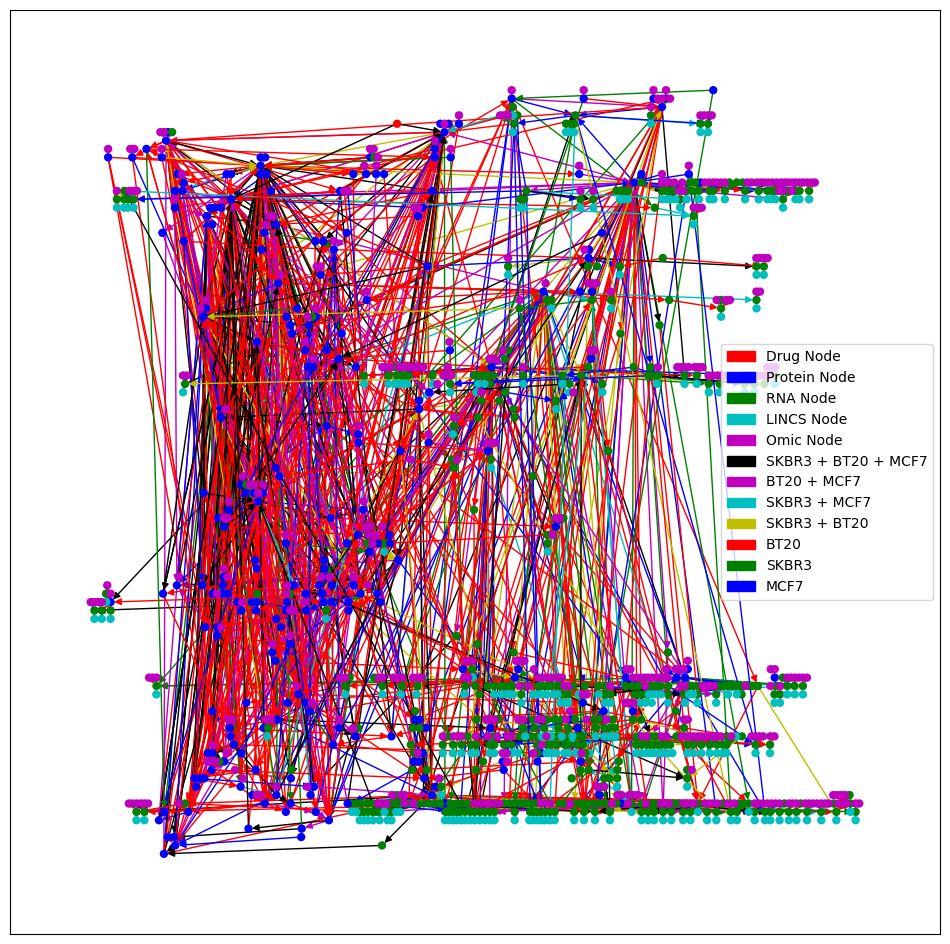

In [ ]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

node_colors = [] 

_DRUGCOLOR = 'r'
_PROTEINCOLOR = 'b'
_RNACOLOR = 'g'
_LINCSCOLOR = 'c'
_OMICSCOLOR = 'm'

for node in G.nodes(): 

    type_ = node.split('__')[0]
    if type_ == 'DRUG': 
        node_colors.append(_DRUGCOLOR)
    elif type_ == 'PROTEIN': 
        node_colors.append(_PROTEINCOLOR)
    elif type_ == 'RNA': 
        node_colors.append(_RNACOLOR)
    elif type_ == 'LINCS': 
        node_colors.append(_LINCSCOLOR)
    else: 
        # omic node
        node_colors.append(_OMICSCOLOR)

edge_colors = []

_ALLLINES = 'k'
_BT_MC = 'm' # r + b  ~ purple 
_MC_SK = 'c' # b + g ~ cyan 
_BT_SK = 'y' # r + g ~ yellow
_BT = 'r'
_SK = 'g'
_MC = 'b'


for edge in G.edges():
    if G.edges[edge]['bt20'] & G.edges[edge]['mcf7'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_ALLLINES)
    elif G.edges[edge]['bt20'] & G.edges[edge]['mcf7']: 
        edge_colors.append(_BT_MC)
    elif G.edges[edge]['mcf7'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_MC_SK)
    elif G.edges[edge]['bt20'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_BT_SK)
    elif G.edges[edge]['bt20']: 
        edge_colors.append(_BT)
    elif G.edges[edge]['mcf7']: 
        edge_colors.append(_MC)
    elif G.edges[edge]['skbr3']: 
        edge_colors.append(_SK)
    else: 
        edge_colors.append(_INACTIVEEDGE)

plt.figure(figsize=(12,12))

drug_patch = mpatches.Patch(color=_DRUGCOLOR, label='Drug Node')
prot_patch = mpatches.Patch(color=_PROTEINCOLOR, label='Protein Node')
_rna_patch = mpatches.Patch(color=_RNACOLOR, label='RNA Node')
linc_patch = mpatches.Patch(color=_LINCSCOLOR, label='LINCS Node')
omic_patch = mpatches.Patch(color=_OMICSCOLOR, label='Omic Node')

allmp = mpatches.Patch(color=_ALLLINES, label='SKBR3 + BT20 + MCF7')
btmcmp = mpatches.Patch(color=_BT_MC, label='BT20 + MCF7')
mcskmp = mpatches.Patch(color=_MC_SK, label='SKBR3 + MCF7')
btskmp = mpatches.Patch(color=_BT_SK, label='SKBR3 + BT20')
btmp = mpatches.Patch(color=_BT, label='BT20')
skmp = mpatches.Patch(color=_SK, label='SKBR3')
mcmp = mpatches.Patch(color=_MC, label='MCF7')

nx.draw_networkx_edges(G, pos=pos, node_size=25, edge_color=edge_colors)
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors, alpha=1.)
plt.legend(handles=[drug_patch, prot_patch, _rna_patch, linc_patch, omic_patch, allmp, btmcmp, mcskmp, btskmp, btmp, skmp, mcmp])

#plt.savefig(f'/mnt/c/Users/natha/Documents/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
plt.show()

In [ ]:
tfs = [] 
for i,row in nerdf2.iterrows(): 
    if (row.source.split('__')[0] == 'PROTEIN') & (row.target.split('__')[0] == 'RNA'): 
        tfs.append(row.source)

tfs = np.unique(tfs)
len(tfs)


38

In [ ]:
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

bt20


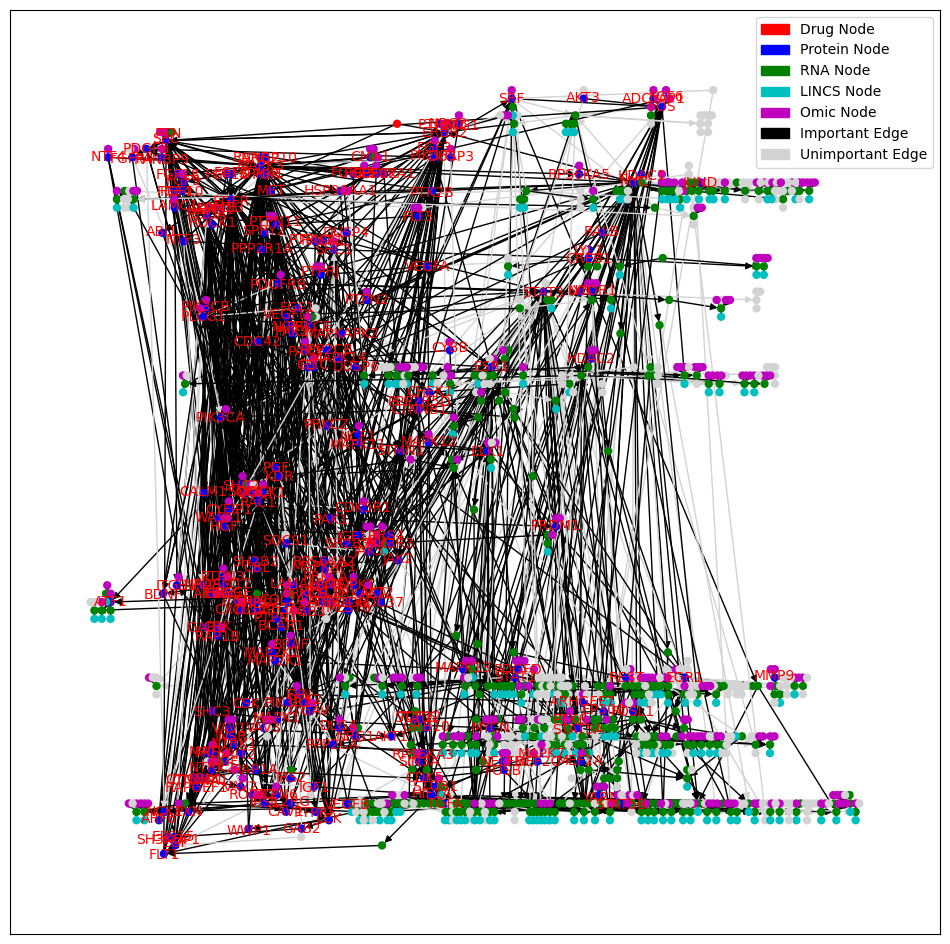

mcf7


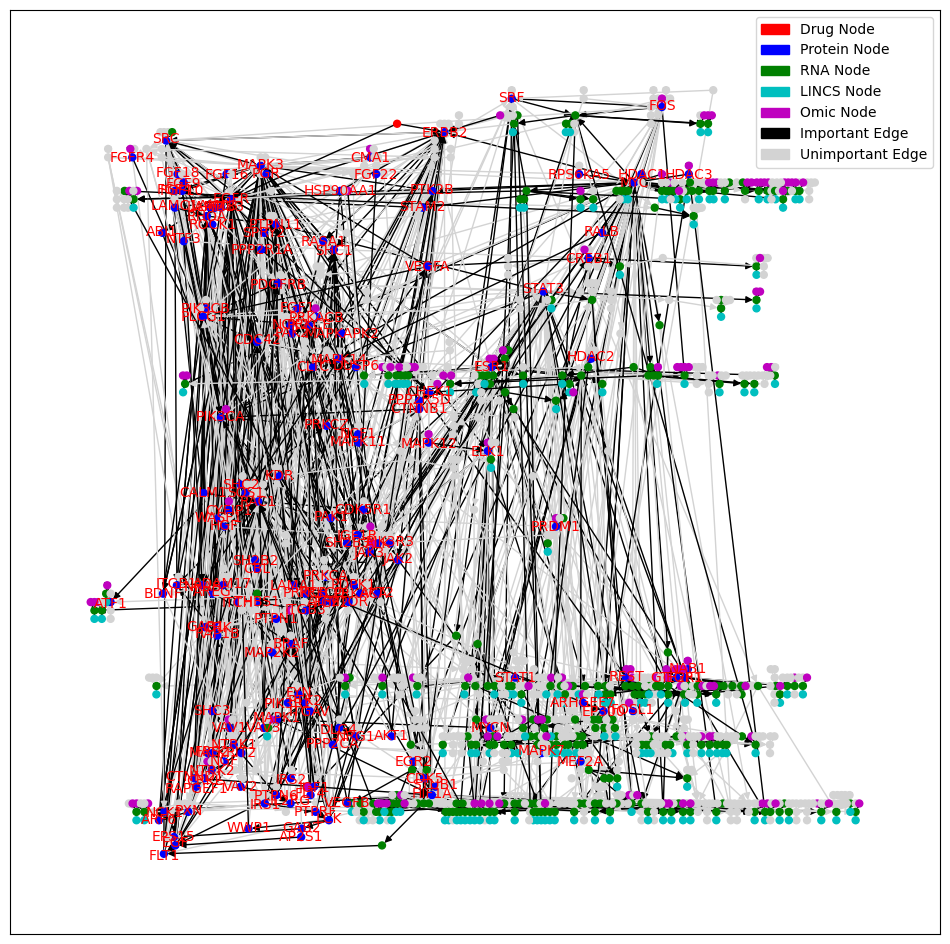

skbr3


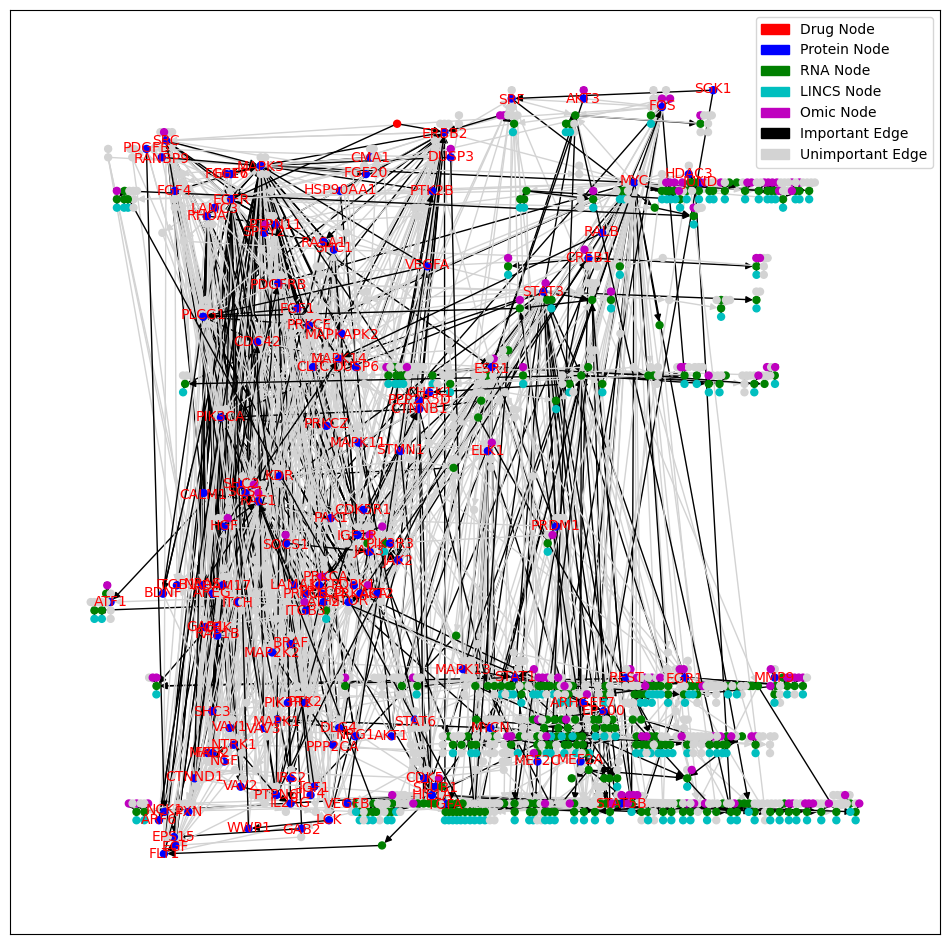

In [ ]:
#NOTE: plots each cell line graph individually. 


pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

for attr in ['bt20', 'mcf7', 'skbr3']: 
    print(attr)

    node_colors = [] 

    _DRUGCOLOR = 'r'
    _PROTEINCOLOR = 'b'
    _RNACOLOR = 'g'
    _LINCSCOLOR = 'c'
    _OMICSCOLOR = 'm'

    node_label_dict = {}

    for node in G.nodes(): 
        
        has_active_edge = False
        for edge in G.edges(node): 
            if G.edges[edge][attr]: 
                has_active_edge = True 
                break 
        for parent in G.predecessors(node): 
            if G.edges[(parent, node)][attr]: 
                has_active_edge = True 
                break 

        if not has_active_edge: 
            node_colors.append('lightgray')
        else: 

            type_ = node.split('__')[0]
            if type_ == 'DRUG': 
                node_colors.append(_DRUGCOLOR)
            elif type_ == 'PROTEIN': 
                node_label_dict[node] = uni2symb[node.split('__')[-1]]
                node_colors.append(_PROTEINCOLOR)
            elif type_ == 'RNA': 
                node_colors.append(_RNACOLOR)
            elif type_ == 'LINCS': 
                node_colors.append(_LINCSCOLOR)
            else: 
                # omic node
                node_colors.append(_OMICSCOLOR)

    edge_colors = []

    _ACTIVEEDGE = 'k'
    _INACTIVEEDGE = 'lightgray'

    for edge in G.edges():
        if G.edges[edge][attr]: 
            edge_colors.append(_ACTIVEEDGE)
        else: 
            edge_colors.append(_INACTIVEEDGE)

    plt.figure(figsize=(12,12))

    drug_patch = mpatches.Patch(color=_DRUGCOLOR, label='Drug Node')
    prot_patch = mpatches.Patch(color=_PROTEINCOLOR, label='Protein Node')
    _rna_patch = mpatches.Patch(color=_RNACOLOR, label='RNA Node')
    linc_patch = mpatches.Patch(color=_LINCSCOLOR, label='LINCS Node')
    omic_patch = mpatches.Patch(color=_OMICSCOLOR, label='Omic Node')

    active_patch = mpatches.Patch(color=_ACTIVEEDGE, label='Important Edge')
    inactive_patch = mpatches.Patch(color=_INACTIVEEDGE, label='Unimportant Edge')

    nx.draw_networkx_edges(G, pos=pos, node_size=25, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos={k:(x, y+10*np.random.randn(1).item()) for k, (x,y) in pos.items()}, font_size=10, labels=node_label_dict, font_color='r', font_weight='normal')
    nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors, alpha=1.)
    plt.legend(handles=[drug_patch, prot_patch, _rna_patch, linc_patch, omic_patch, active_patch, inactive_patch])
    
    #plt.savefig(f'/mnt/c/Users/natha/Documents/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
    #plt.savefig(f'../extdata/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
    plt.show()

In [ ]:
# load ppi context 
ppicontext = pd.read_csv('../../data/ppi_context_v_1_00.txt', sep='\t')
ppicontext.head()

id   gene_a   gene_b       pid cell_name  \
0   0  ALDH1A1  ALDH1A1  25416956       HEK   
1   2  PPP1R9A    ACTG1   9362513      Rat1   
2   2  PPP1R9A    ACTG1   9362513      PC12   
3   2  PPP1R9A    ACTG1   9362513       Sf9   
4   2  PPP1R9A    ACTG1   9362513     COS-7   

                          cell_category cell_sex           cell_species  
0                      Cancer cell line   Female           Homo sapiens  
1  Spontaneously immortalized cell line      NaN      Rattus norvegicus  
2                      Cancer cell line     Male      Rattus norvegicus  
3  Spontaneously immortalized cell line   Female  Spodoptera frugiperda  
4                 Transformed cell line     Male   Chlorocebus aethiops

In [ ]:
[x for x in np.sort(ppicontext.cell_name.unique()).tolist() if 'SK' in x]

['IGSK-1',
 'SK 7',
 'SK-BR-3',
 'SK-BR-7',
 'SK-CO-1',
 'SK-GT-4',
 'SK-HEP-1',
 'SK-LMS-1',
 'SK-LU-1',
 'SK-MEL-1',
 'SK-MEL-10',
 'SK-MEL-100',
 'SK-MEL-103',
 'SK-MEL-108',
 'SK-MEL-14',
 'SK-MEL-147',
 'SK-MEL-2',
 'SK-MEL-239',
 'SK-MEL-24',
 'SK-MEL-28',
 'SK-MEL-31',
 'SK-MEL-37',
 'SK-MEL-5',
 'SK-MES-1',
 'SK-MG-13',
 'SK-MG-7',
 'SK-MM-1',
 'SK-N-AS',
 'SK-N-BE(2)',
 'SK-N-BE(2)-C',
 'SK-N-DZ',
 'SK-N-MC',
 'SK-N-SH',
 'SK-NEP-1',
 'SK-OV-3',
 'SK-PC-1',
 'SK-RC-10',
 'SK-RC-47',
 'SK-UT-1',
 'SKI-DLCL-1',
 'SKNO-1',
 'SKOV3.ip1',
 'SKW 6.4']

In [ ]:
nerdf3 = nerdf2 # nerdf2[lambda x: x.source.str.contains('PROTEIN__') & x.target.str.contains('PROTEIN__')][lambda x: x.source.isin(G.nodes()) & x.target.isin(G.nodes())]
print(nerdf3.shape)
nerdf3 = nerdf3.assign(gene_a = lambda x: [uni2symb[x.split('__')[-1]] if x.split('__')[-1] in uni2symb else None for x in x.source.values])
nerdf3 = nerdf3.assign(gene_b = lambda x: [uni2symb[x.split('__')[-1]] if x.split('__')[-1] in uni2symb else None for x in x.target.values])
nerdf3.head()

(591, 10)


source       target  bt20_score  mcf7_score  skbr3_score   bt20  \
10   PROTEIN__P01106  RNA__P30304    0.031532    0.060274     0.650784  False   
13   PROTEIN__P01106  RNA__P38936    0.023346    0.005095     0.910074  False   
20   PROTEIN__P01106  RNA__P38398    0.005836    0.004118     0.925757  False   
84   PROTEIN__P03372  RNA__P38936    0.021645    0.030348     0.797121  False   
112  PROTEIN__P18146  RNA__P37231    0.012270    0.003229     0.972849  False   

      mcf7  skbr3  at_least_one  all_three gene_a  gene_b  
10   False   True          True      False    MYC  CDC25A  
13   False   True          True      False    MYC  CDKN1A  
20   False   True          True      False    MYC   BRCA1  
84   False   True          True      False   ESR1  CDKN1A  
112  False   True          True      False   EGR1   PPARG

In [ ]:
# ppi context, subset to the 3 cell line world. e.g., only include a ppi context if it appears in at least one of the three cell lines 
ppicontext2 = ppicontext.merge(nerdf3[['gene_a', 'gene_b']], on=['gene_a', 'gene_b'], how='inner')[['gene_a', 'gene_b', 'cell_name']].drop_duplicates()

In [ ]:
nerdf3_bt20 = nerdf3[lambda x: x.bt20][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

# number of important MCF7 edges that were also reported in PPI context 
bt20_res_ = nerdf3_bt20.merge(ppicontext2[lambda x: x.cell_name == 'BT-20'], on=['gene_a', 'gene_b'], how='right')

FP = bt20_res_.IMPORTANT_EDGE.isna().sum()
TP = bt20_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)

0 0
nan nan


invalid value encountered in long_scalars


In [ ]:
nerdf3_mcf7 = nerdf3[lambda x: x.mcf7][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True).drop_duplicates()

# number of important MCF7 edges that were also reported in PPI context 
mcf7_res_ = nerdf3_mcf7.merge(ppicontext2[lambda x: x.cell_name == 'MCF-7'], on=['gene_a', 'gene_b'], how='right')

FP = mcf7_res_.IMPORTANT_EDGE.isna().sum()
TP = mcf7_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)

null_fdr = []
for i in range(1000): 

    rand_mask = np.random.permutation(nerdf3.mcf7.values)
    #rand_mask = np.random.randn(nerdf3.mcf7.values.shape[0]) > 0

    nerdf3_rand = nerdf3[rand_mask][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

    # number of important MCF7 edges that were also reported in PPI context 
    rand_res_ = nerdf3_rand.merge(ppicontext2[lambda x: x.cell_name == 'MCF-7'], on=['gene_a', 'gene_b'], how='right')

    FP_ = rand_res_.IMPORTANT_EDGE.isna().sum()
    TP_ = rand_res_.IMPORTANT_EDGE.sum() 
    PPV_ = TP_ / (TP_ + FP_)
    FDR_ = 1 - PPV_

    null_fdr.append(FDR_)

# probability of being attained by random
1-(FDR < null_fdr).mean()

null_fdr


1 9
0.1 0.9


[0.2142857142857143,
 0.16666666666666663,
 0.25,
 0.25,
 0.4,
 0.16666666666666663,
 0.5,
 0.4545454545454546,
 0.3076923076923077,
 0.1428571428571429,
 0.5,
 0.33333333333333337,
 0.3846153846153846,
 0.15384615384615385,
 0.09999999999999998,
 0.25,
 0.33333333333333337,
 0.08333333333333337,
 0.33333333333333337,
 0.36363636363636365,
 0.4545454545454546,
 0.33333333333333337,
 0.4545454545454546,
 0.25,
 0.3076923076923077,
 0.3076923076923077,
 0.33333333333333337,
 0.4545454545454546,
 0.18181818181818177,
 0.1428571428571429,
 0.0714285714285714,
 0.09090909090909094,
 0.23076923076923073,
 0.15384615384615385,
 0.15384615384615385,
 0.16666666666666663,
 0.18181818181818177,
 0.3076923076923077,
 0.25,
 0.15384615384615385,
 0.36363636363636365,
 0.46153846153846156,
 0.4545454545454546,
 0.3846153846153846,
 0.33333333333333337,
 0.23076923076923073,
 0.25,
 0.09999999999999998,
 0.16666666666666663,
 0.46153846153846156,
 0.18181818181818177,
 0.3076923076923077,
 0.2727272

In [ ]:
for i,row in mcf7_res_.assign(GSNN_EDGE = lambda x: x.IMPORTANT_EDGE == True).iterrows(): 
    print(f'{row.gene_a} & {row.gene_b} & {row.GSNN_EDGE}', end=' \\\\ \\hline\n')

BRCA1 & BRCA1 & False \\ \hline
BNIP3 & BNIP3 & False \\ \hline
CDKN2A & CDKN2A & False \\ \hline
EGFR & EGFR & False \\ \hline
ESR1 & ESR1 & True \\ \hline
APP & APP & False \\ \hline
MYC & MYC & False \\ \hline
MUC1 & MUC1 & False \\ \hline
STUB1 & STUB1 & False \\ \hline
CDK4 & CDK4 & False \\ \hline


In [ ]:
nerdf3_skbr3 = nerdf3[lambda x: x.skbr3][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

# number of important MCF7 edges that were also reported in PPI context 
skbr3_res_ = nerdf3_skbr3.merge(ppicontext2[lambda x: x.cell_name == 'SK-BR-3'], on=['gene_a', 'gene_b'], how='right')

FP = skbr3_res_.IMPORTANT_EDGE.isna().sum()
TP = skbr3_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)



0 2
0.0 1.0


In [ ]:
nerdf3_bt20 = nerdf3[lambda x: x.bt20]
nerdf3_bt20.merge(ppicontext[lambda x: x.cell_name == 'BT-20'], on=['gene_a', 'gene_b'], how='inner')

Empty DataFrame
Columns: [source, target, bt20_score, mcf7_score, skbr3_score, bt20, mcf7, skbr3, at_least_one, all_three, gene_a, gene_b, id, pid, cell_name, cell_category, cell_sex, cell_species]
Index: []

In [ ]:
set(list(pos.keys())).difference(set(list(G.nodes())))

set()

In [ ]:
set(list(pos.keys()))

{'CNV__O15392',
 'CNV__P00533',
 'CNV__P01111',
 'CNV__P05556',
 'CNV__P15407',
 'CNV__P16035',
 'CNV__Q14289',
 'EXPR__P01106',
 'EXPR__P03372',
 'EXPR__P05556',
 'EXPR__P15407',
 'EXPR__P30304',
 'EXPR__Q07889',
 'EXPR__Q9NQC1',
 'LINCS__O00762',
 'LINCS__O14757',
 'LINCS__O15392',
 'LINCS__P00533',
 'LINCS__P05067',
 'LINCS__P06241',
 'LINCS__P06493',
 'LINCS__P11802',
 'LINCS__P12004',
 'LINCS__P15407',
 'LINCS__P16035',
 'LINCS__P16949',
 'LINCS__P20248',
 'LINCS__P30281',
 'LINCS__P30304',
 'LINCS__P38398',
 'LINCS__P38936',
 'LINCS__P53350',
 'LINCS__Q04724',
 'LINCS__Q08257',
 'LINCS__Q13794',
 'LINCS__Q9UNS1',
 'METHYL__P01100',
 'METHYL__P03372',
 'METHYL__P09038',
 'METHYL__P30304',
 'PROTEIN__O15379',
 'PROTEIN__O15530',
 'PROTEIN__O43597',
 'PROTEIN__O76093',
 'PROTEIN__P00533',
 'PROTEIN__P01100',
 'PROTEIN__P01106',
 'PROTEIN__P01111',
 'PROTEIN__P01112',
 'PROTEIN__P03372',
 'PROTEIN__P04198',
 'PROTEIN__P05106',
 'PROTEIN__P05556',
 'PROTEIN__P06239',
 'PROTEIN__P06241

In [ ]:
set(list(G.nodes()))

{'CNV__O15392',
 'CNV__P00533',
 'CNV__P01111',
 'CNV__P05556',
 'CNV__P15407',
 'CNV__P16035',
 'CNV__Q14289',
 'EXPR__P01106',
 'EXPR__P03372',
 'EXPR__P05556',
 'EXPR__P15407',
 'EXPR__P30304',
 'EXPR__Q07889',
 'EXPR__Q9NQC1',
 'LINCS__O00762',
 'LINCS__O14757',
 'LINCS__O15392',
 'LINCS__P00533',
 'LINCS__P05067',
 'LINCS__P06241',
 'LINCS__P06493',
 'LINCS__P11802',
 'LINCS__P12004',
 'LINCS__P15407',
 'LINCS__P16035',
 'LINCS__P16949',
 'LINCS__P20248',
 'LINCS__P30281',
 'LINCS__P30304',
 'LINCS__P38398',
 'LINCS__P38936',
 'LINCS__P53350',
 'LINCS__Q04724',
 'LINCS__Q08257',
 'LINCS__Q13794',
 'LINCS__Q9UNS1',
 'METHYL__P01100',
 'METHYL__P03372',
 'METHYL__P09038',
 'METHYL__P30304',
 'PROTEIN__O15379',
 'PROTEIN__O15530',
 'PROTEIN__O43597',
 'PROTEIN__O76093',
 'PROTEIN__P00533',
 'PROTEIN__P01100',
 'PROTEIN__P01106',
 'PROTEIN__P01111',
 'PROTEIN__P01112',
 'PROTEIN__P03372',
 'PROTEIN__P04198',
 'PROTEIN__P05106',
 'PROTEIN__P05556',
 'PROTEIN__P06239',
 'PROTEIN__P06241

KeyError: 'PROTEIN__P01100'

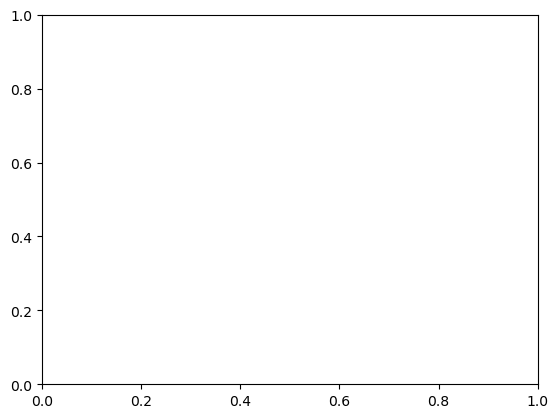

In [ ]:
plt.figure()
nx.draw_networkx_edges(G, pos=pos)

plt.show()

In [ ]:
model.cpu()(X[[1502]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.4045,  1.1248,  3.8501,  0.4797, -1.4882, -2.3810,  0.7249, -2.2067,
         -0.1551,  0.3875, -1.3970]])

In [ ]:
model.cpu()(X[[16495]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.1636,  0.1775,  2.6569,  0.8054, -0.9038,  0.8106,  0.6587,  0.1596,
         -0.0127, -0.3620, -1.0718]])

In [ ]:
# lung cancer 
ELK_NERATINIB_A549 = explainer.explain(X[[18915]], targets=ELK_LINCS_targ_idxs, weight_decay=0, beta=10, iters=1000)

In [ ]:
model.cpu()(X[[18915]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.4355,  0.0196,  1.4991,  0.5416, -0.5329, -0.3395,  0.3494,  0.1289,
         -0.1935,  0.1341, -0.3573]])

In [ ]:
# melanoma (skin cancer)
ELK_NERATINIB_A375 = explainer.explain(X[[22366]], targets=ELK_LINCS_targ_idxs, weight_decay=0, beta=10, iters=1000)

In [ ]:
model.cpu()(X[[22366]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.8208,  0.2433,  1.2894,  0.4925, -0.5565, -0.3107,  0.3159,  0.0357,
          0.0125,  0.3991, -1.0475]])

In [ ]:
ELK_NERATINIB_PC3[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')]

source           target     score
10328  DRUG__BRD-K07955840  PROTEIN__P42345  0.978079
10702  DRUG__BRD-K52522949  PROTEIN__O15379  1.000000
10839  DRUG__BRD-K64606589  PROTEIN__O15379  0.999949
10861  DRUG__BRD-K68174511  PROTEIN__P42345  1.000000
11165  DRUG__BRD-K86797399  PROTEIN__O15379  1.000000

In [ ]:
ELK_NERATINIB_A549[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')]

source           target     score
11165  DRUG__BRD-K86797399  PROTEIN__O15379  0.999999

In [ ]:
BRD-K85606544

In [ ]:
src

array(['PROTEIN__P01106', 'PROTEIN__P42224', 'PROTEIN__P40763', ...,
       'MUT__Q9Y6I3', 'MUT__Q9Y6N6', 'MUT__Q9Y6W5'], dtype='<U19')

In [ ]:
sigidinfo[lambda x: x.pert_id == 'BRD-K61397605'][['pert_id', 'pert_dose', 'sig_id']]

pert_id  pert_dose                 sig_id
1010   BRD-K61397605   1.111110  REP.A015_A375_24H:P15
1665   BRD-K61397605   2.307690   REP.B015_PC3_24H:P13
1829   BRD-K61397605   2.307690  REP.B015_MCF7_24H:P13
2828   BRD-K61397605   0.769231  REP.B015_MCF7_24H:P14
3026   BRD-K61397605   0.256410  REP.B015_MCF7_24H:P15
...              ...        ...                    ...
26930  BRD-K61397605   0.085470   REP.B015_PC3_24H:P16
27088  BRD-K61397605   3.333330   REP.A015_PC3_24H:P14
27170  BRD-K61397605   0.041152   REP.A015_PC3_24H:P18
27607  BRD-K61397605  10.000000   LKCP001_U2OS_24H:D22
27700  BRD-K61397605  10.000000   LKCP001_MCF7_24H:D22

[61 rows x 3 columns]

# Example Plots 

Plot 3 different cell lines; same drug and dose. 

Target 

# GSNNExplainer Replicate Stability 

In [ ]:
xidx = 1665 
sig_ids[xidx]

'REP.B015_PC3_24H:P13'

In [ ]:
# tip: strong prior, big beta and run until it converges (lots of iters)

explainer = GSNNExplainer(model, data, hard=True, prior=2)
edgedf1 = explainer.explain(X[[xidx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=10, iters=1000)
edgedf2 = explainer.explain(X[[xidx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=10, iters=1000)
#edgedf2 = explainer.explain(X[[xidx]], targets=None, lr=1e-2, beta=1e-1, batch=25)

In [ ]:
confusion_matrix(edgedf1.score > 0.5, edgedf2.score > 0.5)

array([[14263,    53],
       [   45,  1453]])

In [ ]:
confusion_matrix(edgedf1.score > 0.5, edgedf2.score > 0.5) / len(edgedf1)

array([[0.90192235, 0.00335146],
       [0.00284558, 0.09188061]])

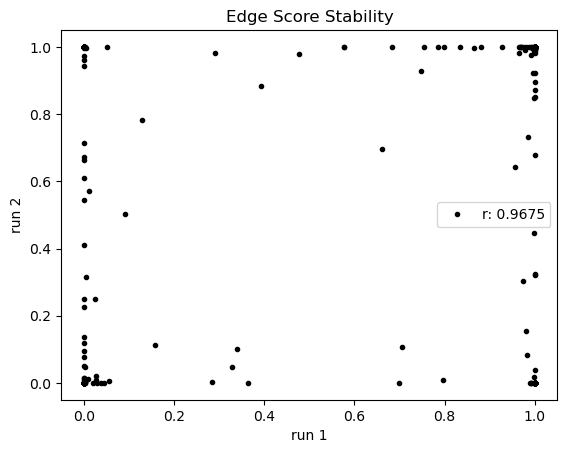

In [ ]:
plt.figure()
plt.plot(edgedf1.score, edgedf2.score, 'k.', label=f'r: {np.corrcoef(edgedf1.score, edgedf2.score)[0,1]:.4f}')
plt.xlabel('run 1')
plt.ylabel('run 2')
plt.title('Edge Score Stability')
plt.legend()
plt.show()

In [ ]:
subedges = edgedf1[lambda x: x.score > 0.5]
subnodes = np.unique(subedges.source.values.tolist() + subedges.target.values.tolist())
len(subnodes)

1157

In [ ]:
edgedf1[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)#[lambda x: x.source == 'DRUG__' + siginfo.set_index('sig_id').loc[sig_ids[xidx]][['pert_id']].item()]

source           target         score
10758  DRUG__BRD-K61397605  PROTEIN__Q13547  1.000000e+00
10756  DRUG__BRD-K61397605  PROTEIN__O15379  9.999999e-01
10299  DRUG__BRD-K02130563  PROTEIN__Q92769  7.854854e-09
11165  DRUG__BRD-K86797399  PROTEIN__O15379  1.125857e-09
10759  DRUG__BRD-K61397605  PROTEIN__Q92769  1.099427e-09
10391  DRUG__BRD-K17743125  PROTEIN__O15379  4.231074e-10
10364  DRUG__BRD-K14529030  PROTEIN__P40763  3.779971e-10
10354  DRUG__BRD-K12867552  PROTEIN__O15379  3.115291e-10
10770  DRUG__BRD-K64052750  PROTEIN__O15264  3.001712e-10
10839  DRUG__BRD-K64606589  PROTEIN__O15379  2.639504e-10

In [ ]:
edgedf2[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)#[lambda x: x.source == 'DRUG__' + siginfo.set_index('sig_id').loc[sig_ids[xidx]][['pert_id']].item()]

source           target         score
10758  DRUG__BRD-K61397605  PROTEIN__Q13547  1.000000e+00
10756  DRUG__BRD-K61397605  PROTEIN__O15379  9.225526e-01
10299  DRUG__BRD-K02130563  PROTEIN__Q92769  1.660771e-08
11165  DRUG__BRD-K86797399  PROTEIN__O15379  1.952612e-09
10759  DRUG__BRD-K61397605  PROTEIN__Q92769  9.561572e-10
10391  DRUG__BRD-K17743125  PROTEIN__O15379  4.841070e-10
10354  DRUG__BRD-K12867552  PROTEIN__O15379  4.203508e-10
10770  DRUG__BRD-K64052750  PROTEIN__O15264  3.101625e-10
10364  DRUG__BRD-K14529030  PROTEIN__P40763  3.055998e-10
10987  DRUG__BRD-K78431006  PROTEIN__O15264  2.711086e-10